# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Цель
Спрогнозировать отток клиентов для своевременного реагирования бизнеса с дальнейшей возможностью реализации ряда действий, чтобы удеражть клиента.

## Задачи
- Загрузить и осмотреть данные
- Провести EDA
- Подготовить данные
- Построить модели и выбрать лучшую

## Загрузка данных и первичный анализ

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import phik
from warnings import simplefilter

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
try:
    data_contract = pd.read_csv('./contract_new.csv')
    data_personal = pd.read_csv('./personal_new.csv')
    data_internet = pd.read_csv('./internet_new.csv')
    data_phone = pd.read_csv('./phone_new.csv')
except:
    data_contract = pd.read_csv('/datasets/contract_new.csv')
    data_personal = pd.read_csv('/datasets/personal_new.csv')
    data_internet = pd.read_csv('/datasets/internet_new.csv')
    data_phone = pd.read_csv('/datasets/phone_new.csv')

### Рассмотрим data_contract

In [3]:
data_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [4]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
data_contract.duplicated().sum()

0

In [6]:
# приведем к нижнему регистру

data_contract.columns = map(str.lower, data_contract.columns)

In [7]:
# check totalcharges

sorted(data_contract['totalcharges'].unique())

[' ',
 '100.17',
 '100.19',
 '100.2',
 '100.24',
 '100.25',
 '100.4',
 '100.75',
 '100.88',
 '100.9',
 '100.94',
 '1000.0',
 '1000.12',
 '1000.43',
 '1001.0',
 '1001.1',
 '1001.81',
 '1002.05',
 '1002.13',
 '1002.46',
 '1003.15',
 '1003.93',
 '1004.08',
 '1005.2',
 '1005.3',
 '1006.0',
 '1006.95',
 '1007.1',
 '1007.5',
 '1008.37',
 '1008.45',
 '1008.48',
 '1008.58',
 '1008.6',
 '1008.8',
 '1009.65',
 '1009.8',
 '101.0',
 '101.2',
 '101.25',
 '101.75',
 '1010.1',
 '1010.65',
 '1011.66',
 '1012.35',
 '1012.5',
 '1013.27',
 '1013.5',
 '1014.75',
 '1015.07',
 '1015.2',
 '1016.6',
 '1017.45',
 '1017.9',
 '1018.37',
 '1018.77',
 '1018.8',
 '1019.4',
 '102.01',
 '102.25',
 '102.38',
 '102.41',
 '102.61',
 '102.64',
 '102.75',
 '102.8',
 '1020.6',
 '1021.76',
 '1021.8',
 '1023.51',
 '1023.8',
 '1023.85',
 '1024.06',
 '1024.1',
 '1027.31',
 '1028.98',
 '1028.99',
 '103.25',
 '103.52',
 '103.55',
 '103.84',
 '1030.26',
 '1031.05',
 '1032.2',
 '1032.35',
 '1033.6',
 '1033.85',
 '1034.28',
 '1035.

In [8]:
data_contract['begindate'].sort_values().unique()

array(['2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
       '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
       '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
       '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
       '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
       '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
       '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
       '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
       '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
       '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
       '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
       '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
       '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
       '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-

In [9]:
data_contract['enddate'].sort_values().unique()

array(['2014-06-01', '2014-09-01', '2014-10-01', '2014-11-01',
       '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
       '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
       '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
       '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
       '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
       '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
       '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
       '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
       '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
       '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
       '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
       '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
       '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
       '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
       '2019-08-01', '2019-09-01', '2019-10-01', '2019-

In [10]:
upload_date = datetime.datetime(2020, 2, 1)

In [11]:
# меняем No на текущую дату в data_contract

data_contract.loc[data_contract['enddate'] == 'No', 'enddate'] = upload_date.strftime('%Y-%m-%d')

- Долго думала, что с этим делать, в итоге все No заменила на текущую дату. 
- Думала, что этот признак будет скорее всего целевым и так как у нас классификация, будет правильнее заменить все No на 0, а даты на 1. Чтобы грубо говоря у нас было да/нет на вопрос закончился ли контракт. Но потом поняла, что это помешает в дальнейшем анализе данных и лучше я просто добавлю новый признак.

In [12]:
# изменим типы данных

data_contract['begindate'] =  pd.to_datetime(data_contract['begindate'])
data_contract['enddate'] =  pd.to_datetime(data_contract['enddate'])
data_contract['totalcharges'] = data_contract['totalcharges'].replace(' ','0', regex=True).astype(float)

In [13]:
# check

data_contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50


In [14]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [15]:
# check

data_contract.describe()

,monthlycharges,totalcharges
count,7043.000000,7043.000000
mean,64.761692,2115.312885
std,30.090047,2112.742814
min,18.250000,0.000000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


#### вывод по data_contract:
- всего 7043 записи, 8 столбцов
- BeginDate заменила тип данных на дату
- EndDate заменила тип данных на int, сделав столбец сначала категориальным, затем числовым. No = 0 человек еще имеет контракт с компанией, все даты перевела в 1 - контракт закончился.
- TotalCharges изменила на float64
- Пропусков нет
- Столбцы привела к нижнему регистру 
- Дубликатов нет
- Аномалий нет

### Рассмотрим data_personal

In [16]:
data_personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [17]:
data_personal['SeniorCitizen'].unique()

array([0, 1])

In [18]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [19]:
data_personal.duplicated().sum()

0

In [20]:
data_personal.columns = map(str.lower, data_personal.columns)

In [21]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


#### вывод по data_personal:
- 7043 записи, 5 столбцов
- Пропусков нет
- Дубликтов нет
- Столбцы привела к нижнему регистру
- Аномалий нет

### Рассмотрим data_internet

In [22]:
data_internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [23]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [24]:
data_internet.duplicated().sum()

0

In [25]:
data_internet.columns = map(str.lower, data_internet.columns)

In [26]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


#### Вывод по data_internet:
- 5517 записей, 8 столбцов
- Пропусков нет
- Дубликатов нет
- Столбцы привела к нижнему регистру
- Аномалий нет

### Рассмотрим data_phone

In [27]:
data_phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [28]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [29]:
data_phone.duplicated().sum()

0

In [30]:
data_phone.columns = map(str.lower, data_phone.columns)

In [31]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


#### Вывод по data_phone:
- 6361 запись, 2 столбца
- Пропусков нет
- Дубликатов нет
- Столбцы привела к нижнему регистру
- Аномалий нет

### Общий вывод:
- в data_contract и data_personal по 7043 записи. В data_internet 5517 записей, data_phone - 6361 запись
- во всех таблицах нет пропусков, дубликатов и столбцы записаны с использованием заглавных и строчных букв (привела к нижнему регистру)
- в data_contract измененила типы данных столбцов BeginDate, EndDate и TotalCharges
- большинство данных категориальные, нужно будет переводить в числовые
- Очевидно, таблицы нужно объединить для дальнейшего EDA

## Объединение данных

In [32]:
# объединяем таблицы

full_data = data_contract.merge(data_internet, on='customerid', how='left')
full_data = full_data.merge(data_personal, on='customerid', how='left')
full_data = full_data.merge(data_phone, on='customerid', how='left')

In [33]:
full_data.head(10)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Fiber optic,No,No,Yes,No,Yes,Yes,Female,0,No,No,Yes
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Fiber optic,No,Yes,No,No,Yes,No,Male,0,No,Yes,Yes
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,DSL,Yes,No,No,No,No,No,Female,0,No,No,NaN
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Fiber optic,No,No,Yes,Yes,Yes,Yes,Female,0,Yes,No,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,DSL,Yes,Yes,No,No,No,No,Male,0,No,Yes,No


In [34]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   internetservice   5517 non-null   object        
 9   onlinesecurity    5517 non-null   object        
 10  onlinebackup      5517 non-null   object        
 11  deviceprotection  5517 non-null   object        
 12  techsupport       5517 non-null   object        
 13  streamingtv       5517 non-null   object        
 14  streamingmovies   5517 n

In [35]:
full_data.describe()

,monthlycharges,totalcharges,seniorcitizen
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.162147
std,30.090047,2112.742814,0.368612
min,18.250000,0.000000,0.000000
25%,35.500000,436.750000,0.000000
50%,70.350000,1343.350000,0.000000
75%,89.850000,3236.690000,0.000000
max,118.750000,9221.380000,1.000000


### Поиск и обработка пропусков

In [36]:
# создадим 2 функции для графиков get_pass_data_frame и set_label

def get_pass_data_frame(data):
    return (
        data.isnull().sum().sort_values()
        .to_frame()
        .rename(columns = {0: 'space'})
        .query('space > 0')
    )

In [37]:
def set_label(subplot, labels, title):
    subplot.set_title(title, fontdict={'fontsize': 14});
    
    x_label, y_label = labels
    subplot.set_xlabel(x_label, fontsize=14);
    subplot.set_ylabel(y_label, fontsize=14);

In [38]:
pass_data_frame = get_pass_data_frame(full_data)

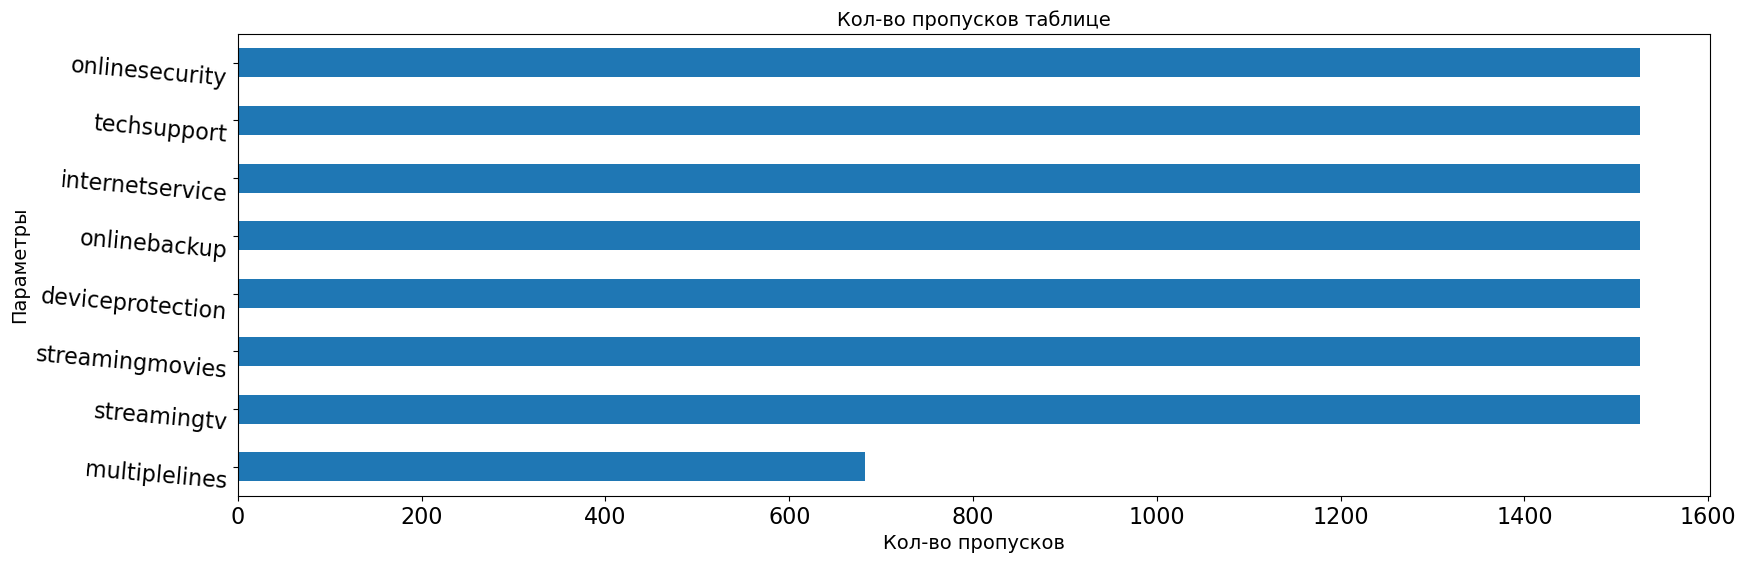

In [39]:
set_label(pass_data_frame.plot(
    kind='barh', 
    figsize=(19, 6), 
    rot=-5, legend=False, 
    fontsize=16
), labels=('Кол-во пропусков', 'Параметры'), title='Кол-во пропусков таблице')

In [40]:
full_data.isna().sum()

customerid             0
begindate              0
enddate                0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
internetservice     1526
onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
gender                 0
seniorcitizen          0
partner                0
dependents             0
multiplelines        682
dtype: int64

- Самое большое кол-во пропусков в столбцах из файла data_internet
- Все эти столбцы категориальные и все, кроме internetservice содержат значения 'yes'/'no'. Думаю, в этих столбцах пропуски можно заполнить значением no, так как у пользователей с пропусками скорее всего интернета нет.
- internetservice можно заполнить значением no_internet
- Пропуски в multiplelines можно заполнить значением no_phone, так как скорее всего у пользователей с пропусками в этом столбце нет телефона.

In [41]:
# заполним пропуски 

full_data[['onlinesecurity', 
           'onlinebackup', 
           'deviceprotection', 
           'techsupport', 
           'streamingtv', 
           'streamingmovies',
           'internetservice',
           'multiplelines']] = full_data[['onlinesecurity', 
                                               'onlinebackup', 
                                               'deviceprotection', 
                                               'techsupport', 
                                               'streamingtv', 
                                               'streamingmovies',
                                               'internetservice',
                                               'multiplelines']].fillna('No')

In [42]:
# check

full_data.isna().sum()

customerid          0
begindate           0
enddate             0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
gender              0
seniorcitizen       0
partner             0
dependents          0
multiplelines       0
dtype: int64

In [43]:
# check

full_data.head(10)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Fiber optic,No,No,Yes,No,Yes,Yes,Female,0,No,No,Yes
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Fiber optic,No,Yes,No,No,Yes,No,Male,0,No,Yes,Yes
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,DSL,Yes,No,No,No,No,No,Female,0,No,No,No
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Fiber optic,No,No,Yes,Yes,Yes,Yes,Female,0,Yes,No,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,DSL,Yes,Yes,No,No,No,No,Male,0,No,Yes,No


In [44]:
full_data.duplicated().sum()

0

### Вывод:
- Данные объеденены
- Пропуски обработаны
- Дубликатов нет

## Исследовательский анализ данных

Важно проанализировать следующие признаки:
- Зависит ли уход клиента от количества дней, прошедших от начала до конца договора 
- Какой тип оплаты используется пользователями оставшимися и ушедшими (type)
- Зависимоть от способа оплаты (paymentmethod)
- Ежемесячные траты на услуги по договору (monthlycharges)
- Всего потрачено денег на услуги (totalcharges)
- Как влияет наличие иждивенцев на уход (dependents)
- Как влияет наличие пенсионного статуса на уход (seniorcitizen)
- Как влияет наличие супруга (partner)
- Зависимость от использования интерент услуг (internetservice, streamingtv, streamingmovies)

### Создадим 2 доп признака

Чтобы отвтеить на первый вопрос, создадим 2 доп признака:
- leave - категориальный признак с 0 и 1 для определения ушел клиент или нет
- day_count - кол-во дней в рамках договора

In [45]:
full_data['leave'] = 0
full_data.loc[full_data['enddate'] < upload_date, 'leave'] = 1

In [46]:
full_data['day_count'] = (full_data['enddate'] - full_data['begindate']) // np.timedelta64(1, 'D') 

In [47]:
full_data.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,...,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,leave,day_count
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,...,No,No,No,Female,0,Yes,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,...,Yes,No,No,Male,0,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,...,No,No,No,Female,0,No,No,No,0,153


### Мультиколлинеарность

In [48]:
correlation_matrix = full_data.iloc[:, 1:].phik_matrix(interval_cols=['monthlycharges', 'totalcharges', 'day_count'])
correlation_matrix

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,...,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,leave,day_count
begindate,1.000000,0.548313,0.766249,0.081447,0.456389,0.421886,0.774207,0.192197,0.403560,0.445583,...,0.399506,0.359784,0.371863,0.011268,0.050862,0.473514,0.208564,0.428109,0.450254,0.978521
enddate,0.548313,1.000000,0.285429,0.062936,0.169262,0.173493,0.217670,0.117099,0.129611,0.203659,...,0.112812,0.164794,0.177561,0.018274,0.090502,0.177492,0.055518,0.209337,1.000000,0.396342
type,0.766249,0.285429,1.000000,0.106860,0.277462,0.388444,0.470860,0.505187,0.152145,0.098884,...,0.179999,0.066961,0.069608,0.000000,0.086231,0.179736,0.147680,0.065498,0.094015,0.634155
paperlessbilling,0.081447,0.062936,0.106860,1.000000,0.370495,0.467812,0.201703,0.231438,0.000000,0.196443,...,0.055929,0.343524,0.325551,0.000000,0.242133,0.013218,0.172593,0.252972,0.083398,0.026799
paymentmethod,0.456389,0.169262,0.277462,0.370495,1.000000,0.399526,0.335666,0.323886,0.262911,0.282475,...,0.272101,0.377209,0.378907,0.000000,0.292725,0.243008,0.224903,0.339313,0.214832,0.350964
monthlycharges,0.421886,0.173493,0.388444,0.467812,0.399526,1.000000,0.710905,0.919002,0.551621,0.629541,...,0.576525,0.835340,0.833307,0.008175,0.304985,0.203545,0.184366,0.675883,0.226280,0.387727
totalcharges,0.774207,0.217670,0.470860,0.201703,0.335666,0.710905,1.000000,0.490081,0.522090,0.622445,...,0.550065,0.641488,0.643210,0.000000,0.135650,0.381958,0.084247,0.573191,0.302890,0.848337
internetservice,0.192197,0.117099,0.505187,0.231438,0.323886,0.919002,0.490081,1.000000,0.241421,0.233602,...,0.239663,0.272818,0.272782,0.000000,0.160702,0.000000,0.108463,0.225383,0.056621,0.060845
onlinesecurity,0.403560,0.129611,0.152145,0.000000,0.262911,0.551621,0.522090,0.241421,1.000000,0.430425,...,0.528391,0.272186,0.289097,0.018397,0.057028,0.221673,0.124945,0.151886,0.132594,0.395693
onlinebackup,0.445583,0.203659,0.098884,0.196443,0.282475,0.629541,0.622445,0.233602,0.430425,1.000000,...,0.445130,0.428007,0.417170,0.009882,0.102065,0.219223,0.031533,0.311403,0.229482,0.414982


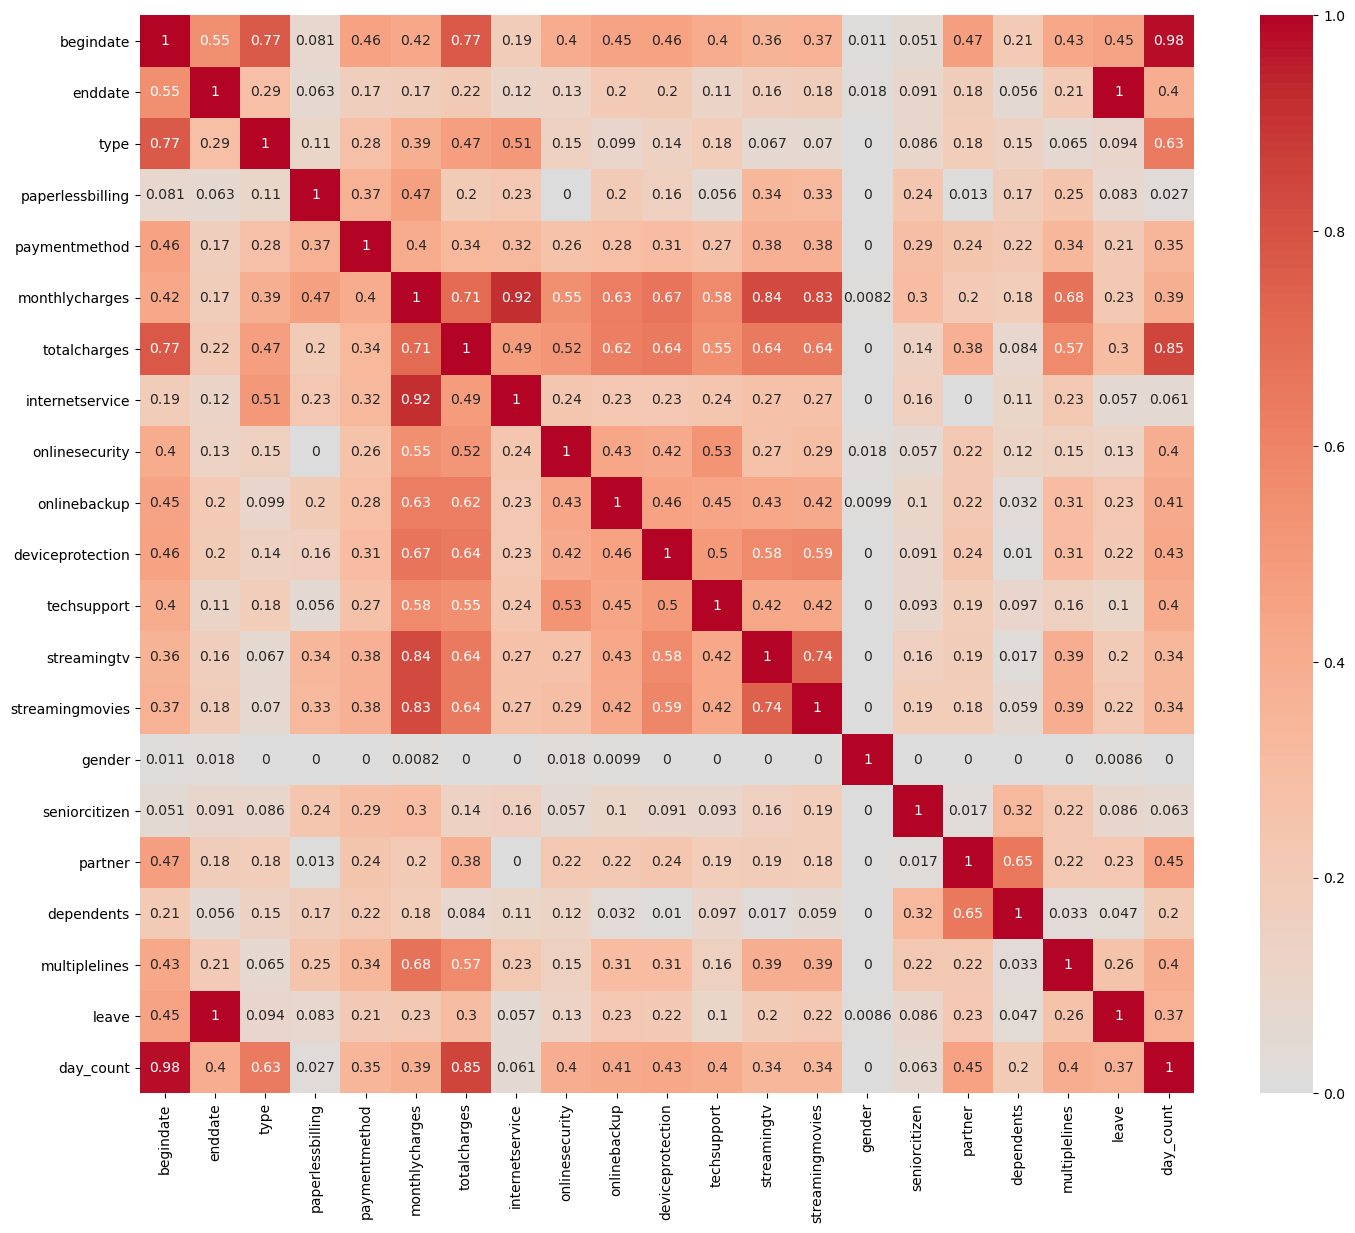

In [49]:
plt.figure(figsize = (17,14))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, annot=True);

#### Вывод
Выделила скоррелиованные признаки с попарной корреляцией от 0.8

Скоррелированные признаки:
- customerid и все признаки
- leave и enddate
- day_count и begindate
- internetservice и monthlycharges
- day_count и leave
- streamingtv и monthlycharges
- streamingmovies и monthlycharges
- day_count и totalcharges

### Зависит ли уход клиента от количества дней, прошедших от начала до конца договора 

In [50]:
# функция для графиков 
    
def create_graph_sns(func, **kwargs):
    fig, ax = plt.subplots(figsize=(15, 5))
    graph = func(**kwargs)
    plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')
    return graph

In [51]:
# создадим таблицу по 2 признакам

dependence_day = full_data.pivot_table(
    index='day_count', 
    values='leave'
)

In [52]:
dependence_day_without_index = dependence_day.reset_index()

In [53]:
dependence_day_without_index.head(10)

,day_count,leave
0,0,0.000000
1,28,1.000000
2,30,1.000000
3,31,0.012712
4,59,1.000000
5,61,1.000000
6,62,0.022222
7,90,1.000000
8,91,1.000000
9,92,0.024691


In [54]:
# исследуем коррелцию

dependence_day_without_index.phik_matrix(interval_cols=['day_count'], bins={'day_count':5})

,day_count,leave
day_count,1.000000,0.506739
leave,0.506739,1.000000


Между признаками day_count и leave средняя взаимосвязь

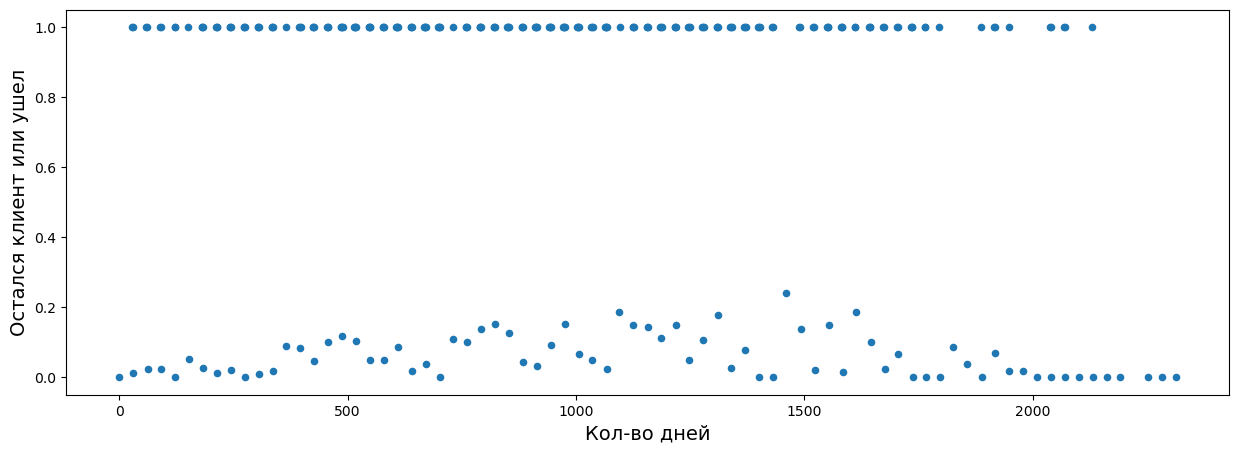

In [55]:
set_label(dependence_day_without_index.plot(kind='scatter',y='leave', x='day_count', figsize=(15, 5)),
          labels=('Кол-во дней', 'Остался клиент или ушел'), title='')

Да, зависит. 
- Все ущедшие клиенты пользовались услугами от 0 до 2000 дней
- Все оставшиеся клиенты пользуются услугами от 1400 до 3700 дней

### Какой тип оплаты используется пользователями оставшимися и ушедшими

In [56]:
# исследуем корреляцию

type_pay_corr = full_data[['leave', 'type']]
type_pay_corr.phik_matrix(interval_cols=[])

,leave,type
leave,1.000000,0.094015
type,0.094015,1.000000


зависимости почти нет

In [57]:
# функция гуппировки

def generate_group_by_table(column, data=full_data): 
    table = full_data[
        ['leave', 'customerid', column]
    ].groupby(by=['leave', column]).count().sort_values(
        by=['leave', 'customerid'], ascending=False
    ).reset_index()  
    return table

In [58]:
type_pay = generate_group_by_table(column='type')
type_pay

,leave,type,customerid
0,1,Month-to-month,407
1,1,Two year,381
2,1,One year,313
3,0,Month-to-month,3468
4,0,Two year,1314
5,0,One year,1160


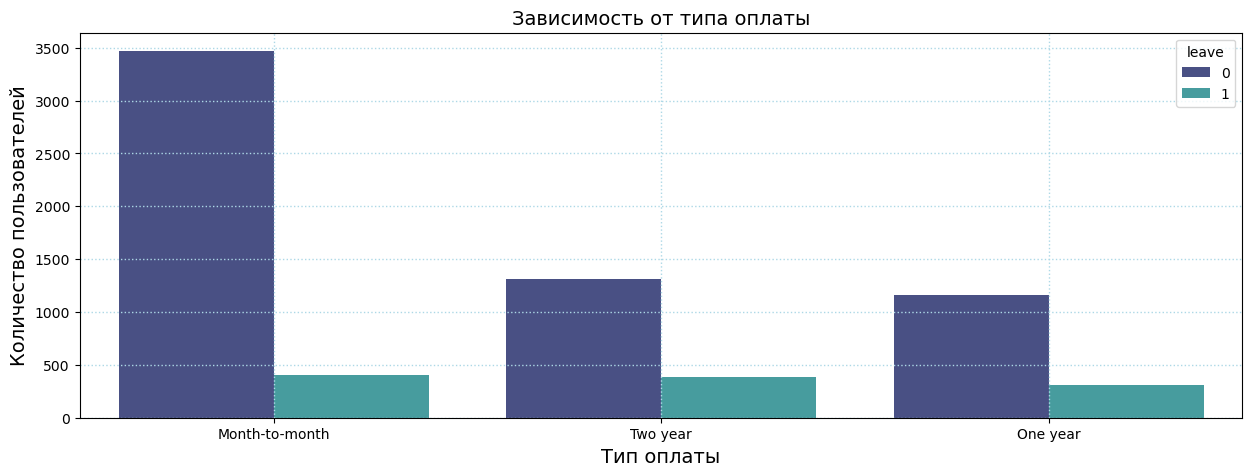

In [59]:
graph = create_graph_sns(
    sns.barplot, 
    data=type_pay,
    hue=type_pay['leave'],
    x=type_pay['type'], 
    y=type_pay['customerid'],
    palette='mako'
)
set_label(graph, ('Тип оплаты', 'Количество пользователей'), title='Зависимость от типа оплаты')
plt.show()

Ушедшие пользователи в основном платили помесячно и раз в 2 года, зависимость слабая

### Зависимоть от способа оплаты (paymentmethod)

In [60]:
paymentmethod_corr = full_data[['leave', 'paymentmethod']]
paymentmethod_corr.phik_matrix(interval_cols=[])

,leave,paymentmethod
leave,1.000000,0.214832
paymentmethod,0.214832,1.000000


зависимость слабая

In [61]:
paymentmethod = generate_group_by_table(column='paymentmethod')
paymentmethod

,leave,paymentmethod,customerid
0,1,Electronic check,350
1,1,Bank transfer (automatic),317
2,1,Credit card (automatic),317
3,1,Mailed check,117
4,0,Electronic check,2015
5,0,Mailed check,1495
6,0,Bank transfer (automatic),1227
7,0,Credit card (automatic),1205


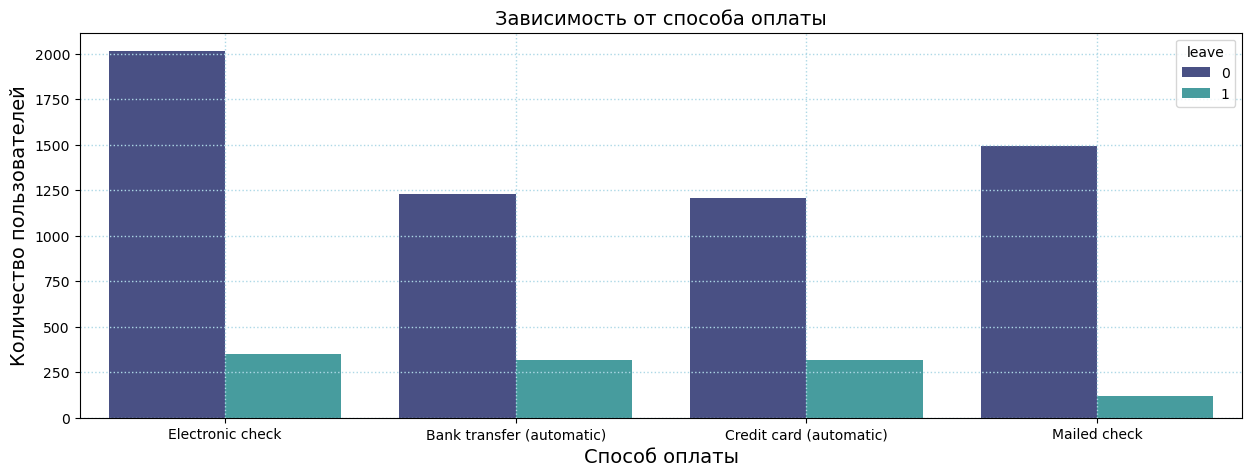

In [62]:
graph = create_graph_sns(
    sns.barplot, 
    data=type_pay,
    hue=paymentmethod['leave'],
    x=paymentmethod['paymentmethod'], 
    y=paymentmethod['customerid'],
    palette='mako'
)
set_label(graph, ('Способ оплаты', 'Количество пользователей'), title='Зависимость от способа оплаты')

plt.show()

ушедшие пользователи оплачивали услуги в осн электронным чеком

### Ежемесячные и общие траты на услуги по договору 

In [63]:
# исследуем корреляцию ежемесячных платежей

monthlycharges_corr = full_data[['leave', 'monthlycharges']]
monthlycharges_corr.phik_matrix(interval_cols=['monthlycharges'])

,leave,monthlycharges
leave,1.00000,0.22628
monthlycharges,0.22628,1.00000


Не понимаю как это работает, вроде ж надо в interval_cols 'monthlycharges' подставлять, но тогда зависимость меньше, хотя она там есть, на графике ж видно)

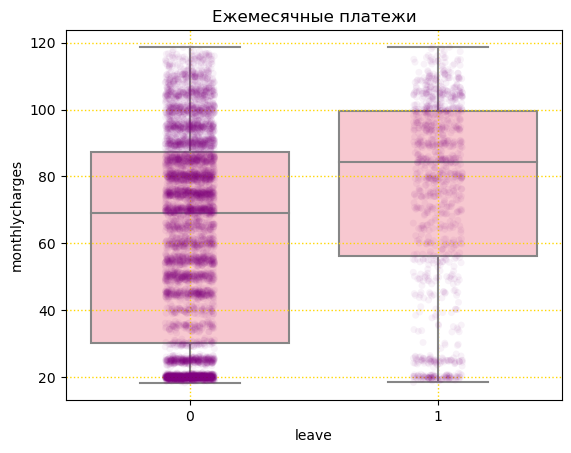

In [64]:
# исследуем график

monthlycharges = sns.boxplot(x='leave', y='monthlycharges', data=full_data, color='pink')
sns.stripplot(x='leave', y='monthlycharges', data=full_data, marker="o", alpha=0.05, color="purple")

monthlycharges.set_title('Ежемесячные платежи')
plt.grid(color = 'gold', linewidth = 1, linestyle=':')

Как видно на графике, у ушедших пользователей стартовый ценник ежемесячного платежа почти в 2 раза больше. И распределение по суммам выше, чем у активных пользователей.

In [65]:
# исследуем корреляцию общих платежей

monthlycharges_corr = full_data[['leave', 'totalcharges']]
monthlycharges_corr.phik_matrix(interval_cols=['totalcharges'])

,leave,totalcharges
leave,1.00000,0.30289
totalcharges,0.30289,1.00000


зависимость сильная

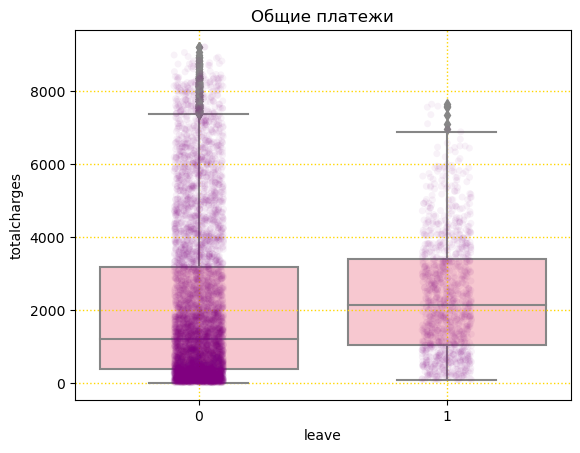

In [66]:
# исследуем график

totalcharges = sns.boxplot(x='leave', y='totalcharges', data=full_data, color='pink')
sns.stripplot(x='leave', y='totalcharges', data=full_data, marker="o", alpha=0.05, color="purple")
totalcharges.set_title('Общие платежи')
plt.grid(color = 'gold', linewidth = 1, linestyle=':')

Всего уплаченных средств также больше у ушедших пользователей

### Как влияет наличие иждивенцев (dependents)

In [67]:
# Исследуем корреляцию

dependents = full_data[['leave', 'dependents']]
dependents.phik_matrix(interval_cols=[])

,leave,dependents
leave,1.000000,0.046871
dependents,0.046871,1.000000


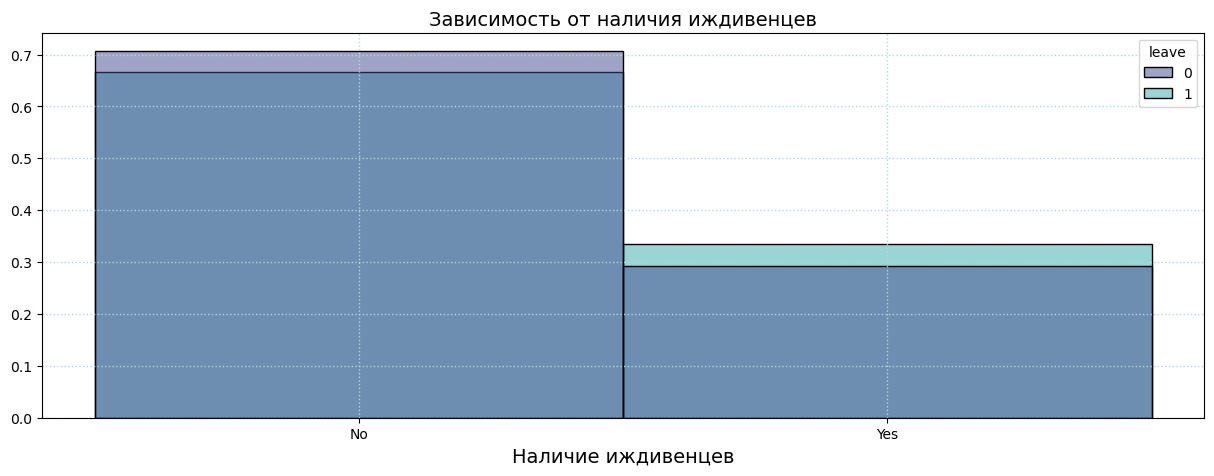

In [68]:
graph = create_graph_sns(
    sns.histplot, 
    data=dependents,
    hue=dependents['leave'],
    x=dependents['dependents'], 
    palette='mako',
    stat="density", common_norm=False
)
set_label(graph, ('Наличие иждивенцев', ''), title='Зависимость от наличия иждивенцев')

plt.show()

Распределение одинаковое, зависимости нет

### Как влияет наличие пенсионного статуса

In [69]:
# Исследуем корреляцию

seniorcitizen = full_data[['leave', 'seniorcitizen']]
seniorcitizen.phik_matrix(interval_cols=[])

,leave,seniorcitizen
leave,1.000000,0.086159
seniorcitizen,0.086159,1.000000


зависимости нет

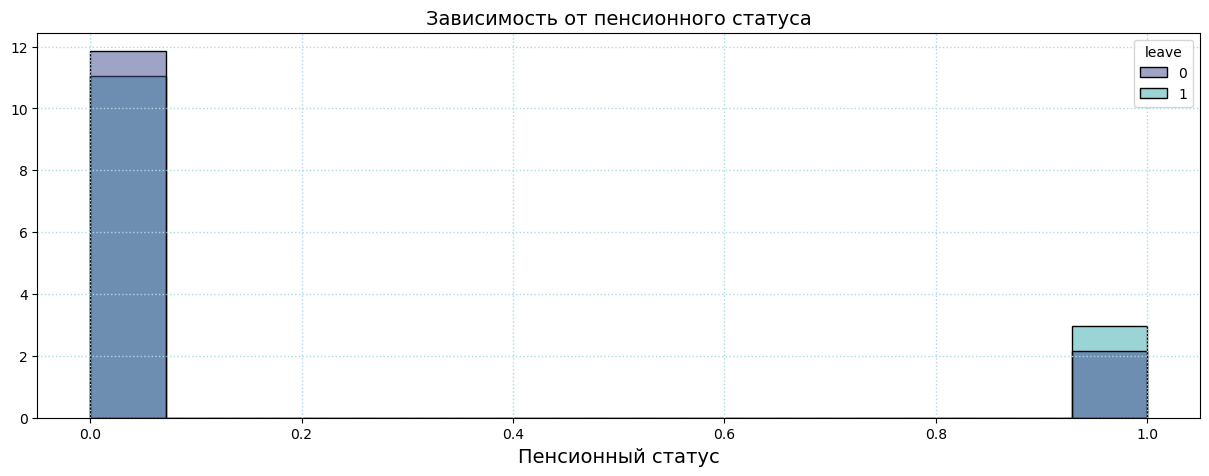

In [70]:
# исследуем график

graph = create_graph_sns(
    sns.histplot, 
    hue=full_data['leave'],
    x=full_data['seniorcitizen'], 
    palette='mako',
    stat="density", common_norm=False
)
set_label(graph, ('Пенсионный статус', ''), title='Зависимость от пенсионного статуса')

plt.show()

Наличие пенсионного статуса не влияет. Одинаковое распределение.

### Как влияет наличие супруга (partner)

In [71]:
# Исследуем корреляцию

partner = full_data[['leave', 'partner']]
partner.phik_matrix(interval_cols=[])

,leave,partner
leave,1.000000,0.226688
partner,0.226688,1.000000


есть слабая зависимоть

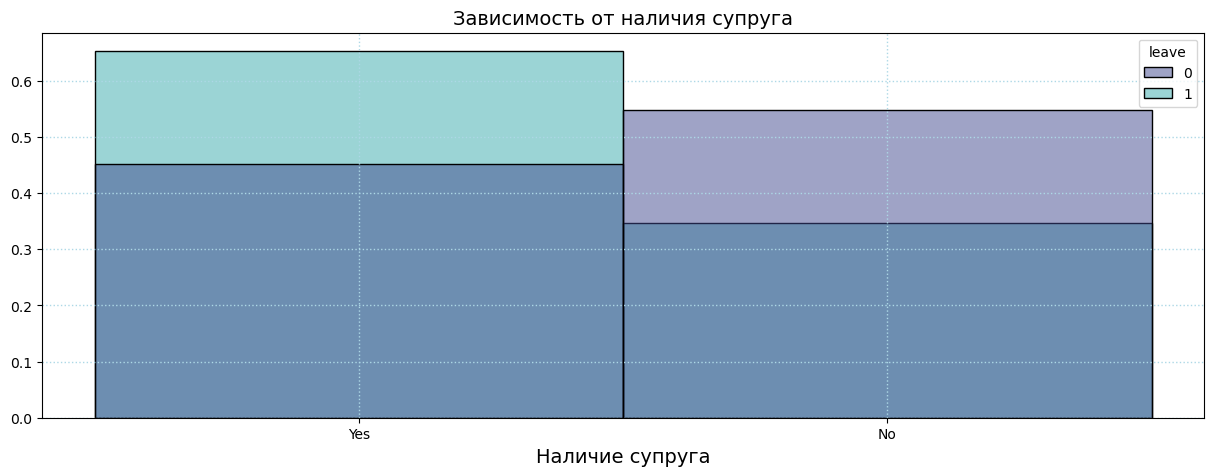

In [72]:
# исследуем график

graph = create_graph_sns(
    sns.histplot, 
    hue=full_data['leave'],
    x=full_data['partner'], 
    palette='mako',
    stat="density", common_norm=False
)
set_label(graph, ('Наличие супруга', ''), title='Зависимость от наличия супруга')

plt.show()

Взаимосвязь по графику слабая. Видно, что люди без партнера - основные пользователи компании. Но не скажу, что это сильно влияет на уход, хоть и бОльшее количество людей с партнером из ушедших.

### Зависимость от использования интерент услуг (internetservice, streamingtv, streamingmovies)

In [73]:
# исследуем корреляцию internetservice

internetservice_corr = full_data[['leave', 'internetservice']]
internetservice_corr.phik_matrix(interval_cols=[])

,leave,internetservice
leave,1.000000,0.056621
internetservice,0.056621,1.000000


зависимости нет

In [74]:
internetservice = generate_group_by_table(column='internetservice')
internetservice

,leave,internetservice,customerid
0,1,Fiber optic,595
1,1,DSL,346
2,1,No,160
3,0,Fiber optic,2501
4,0,DSL,2075
5,0,No,1366


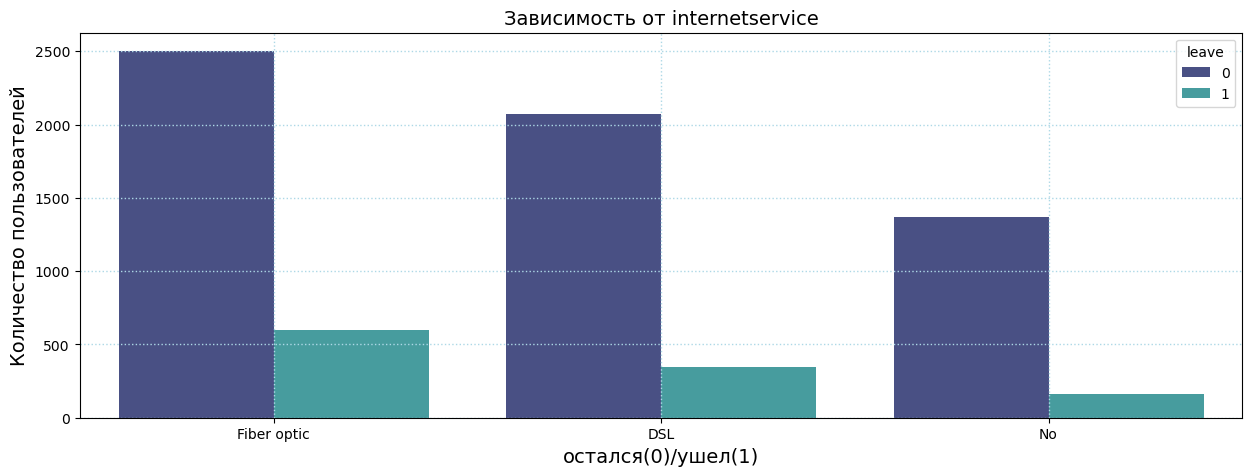

In [75]:
# исследуем график

graph = create_graph_sns(
    sns.barplot, 
    hue=internetservice['leave'],
    data=internetservice,
    x=internetservice['internetservice'], 
    y=internetservice['customerid'],
    palette='mako'
)
set_label(graph, ('остался(0)/ушел(1)', 'Количество пользователей'), title='Зависимость от internetservice')
plt.show()

Распределение одинаковое, зависимость не вижу

In [76]:
# исследуем корреляцию streamingtv

streamingtv_corr = full_data[['leave', 'streamingtv']]
streamingtv_corr.phik_matrix(interval_cols=[])

,leave,streamingtv
leave,1.000000,0.200198
streamingtv,0.200198,1.000000


слабая корреляция

In [77]:
streamingtv = generate_group_by_table(column='streamingtv')
streamingtv

,leave,streamingtv,customerid
0,1,Yes,584
1,1,No,517
2,0,No,3819
3,0,Yes,2123


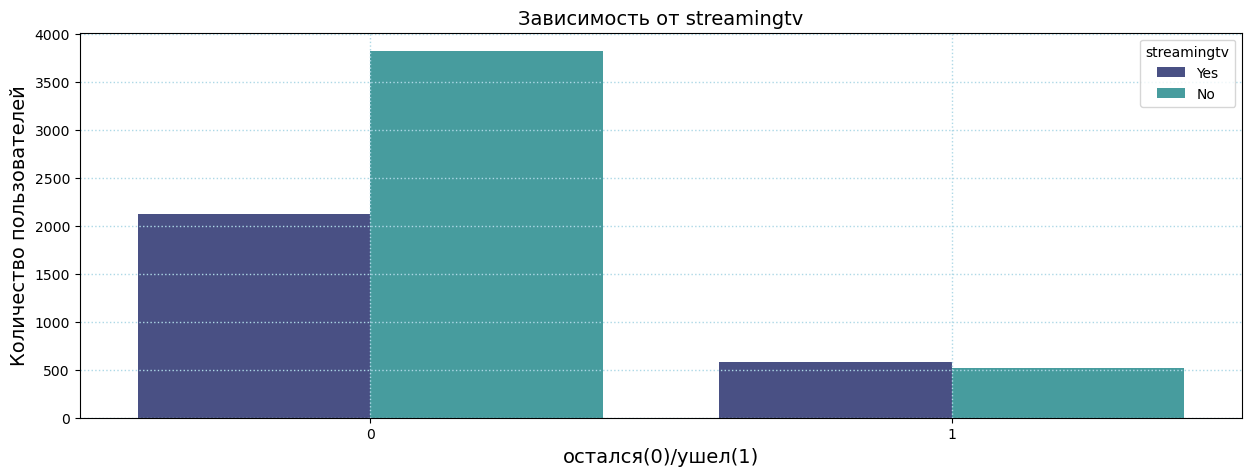

In [78]:
# исследуем график

graph = create_graph_sns(
    sns.barplot, 
    hue=streamingtv['streamingtv'],
    data=streamingtv,
    x=streamingtv['leave'], 
    y=streamingtv['customerid'],
    palette='mako'
)
set_label(graph, ('остался(0)/ушел(1)', 'Количество пользователей'), title='Зависимость от streamingtv')
plt.show()

Из ушедших пользователей чуть больше тех, кто пользовался стриминговым тв

In [79]:
# исследуем корреляцию streamingtv

streamingmovies_corr = full_data[['leave', 'streamingmovies']]
streamingmovies_corr.phik_matrix(interval_cols=[])

,leave,streamingmovies
leave,1.000000,0.222232
streamingmovies,0.222232,1.000000


слабая корреляция

In [80]:
streamingmovies = generate_group_by_table(column='streamingmovies')
streamingmovies

,leave,streamingmovies,customerid
0,1,Yes,606
1,1,No,495
2,0,No,3816
3,0,Yes,2126


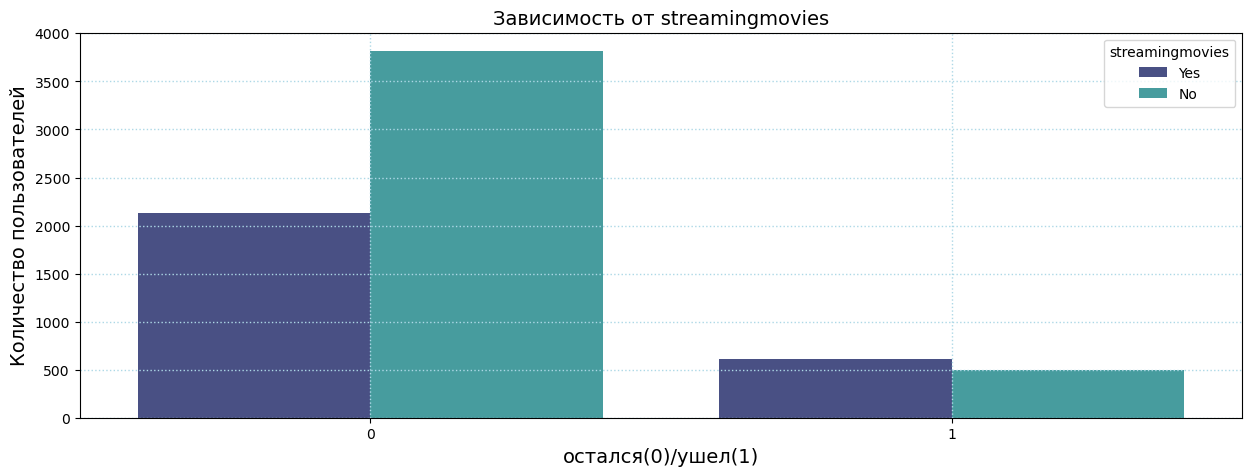

In [81]:
# исследуем график

graph = create_graph_sns(
    sns.barplot, 
    hue=streamingmovies['streamingmovies'],
    data=streamingmovies,
    x=streamingmovies['leave'], 
    y=streamingmovies['customerid'],
    palette='mako'
)
set_label(graph, ('остался(0)/ушел(1)', 'Количество пользователей'), title='Зависимость от streamingmovies')
plt.show()

Из ушедших пользователей чуть больше тех, кто пользовался стриминговым фильмами

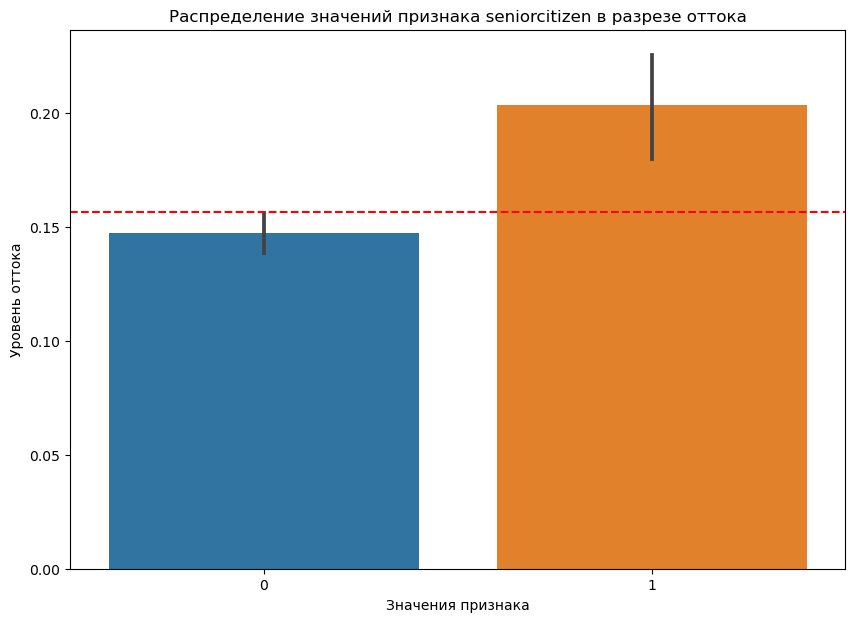

In [82]:
plt.figure(figsize=(10, 7))
sns.barplot(data=full_data, x='seniorcitizen', y='leave')
plt.axhline(full_data['leave'].mean(), color='r', linestyle='--')
plt.title('Распределение значений признака seniorcitizen в разрезе оттока')
plt.xlabel('Значения признака')
plt.ylabel('Уровень оттока');

### Вывод по объединению данных и исследовательскому анализу

#### Объединение данных

- Объединила 4 таблицу в одну без потери данных
- Обработала пропуски:
    - Самое большое кол-во пропусков в столбцах из файла data_internet
    - Все эти столбцы категориальные и все, кроме internetservice содержат значения 'yes'/'no'. В этих столбцах пропуски заполнила значением no, так как у пользователей с пропусками скорее всего интернета нет.
    - internetservice заполнила значением no_internet
    - Пропуски в multiplelines заполнила значением no_phone, так как скорее всего у пользователей с пропусками в этом столбце нет телефона.
- Аномалии не выявлены
- Дубликатов нет
    
#### Исследовательский анализ

- Провела исследовательский анализ. Проверила зависимость ухода клиента от следующих признаков:
    - Количество дней, прошедших от начала до конца договора.
        - Да, зависит. 
        - Корреляция средняя
        - Все ушедшие клиенты пользовались услугами от 0 до 2000 дней
        - Все оставшиеся клиенты пользуются услугами от 1400 до 3700 дней
    - Какой тип оплаты используется пользователями оставшимися и ушедшими (type):
        - Корреляция очень слабая
        - Ушедшие пользователи в основном платили помесячно и раз в 2 года
    - Способ оплаты (paymentmethod):
        - Корреляция слабая
        - Ушедшие пользователи оплачивали услуги по большей части электронным чеком
    - Ежемесячные траты на услуги по договору (monthlycharges)
        - Корреляция слабая
        -  У ушедших пользователей стартовый ценник ежемесячного платежа почти в 2 раза больше. И распределение по суммам выше, чем у активных пользователей.
    - Всего потрачено денег на услуги (totalcharges)
        - Корреляция высокая
        - Всего уплаченных средств также больше у ушедших пользователей
    - Как влияет наличие иждивенцев на уход (dependents)
        - Корреляция очень слабая
        - Распределение одинаковое, зависимости нет
    - Как влияет наличие пенсионного статуса на уход (seniorcitizen)
        - Корреляция очень слабая
        - Распределение одинаковое, зависимости нет
    - Как влияет наличие супруга (partner)
        - Корреляция слабая
        - Взаимосвязь по графику слабая. Видно, что люди без партнера - основные пользователи компании. Но не скажу, что это сильно влияет на уход, хоть и бОльшее количество людей с партнером из ушедших.
    - Зависимость от использования интерент услуг (internetservice, streamingtv, streamingmovies)
        - Корреляция слабая у streamingtv, streamingmovies. Очень слабая у internetservice
        - Зависимость слабая. Из ушедших пользователей чуть больше тех, кто пользовался стриминговым тв и фильмами

## План работ


1. Предобработка данных и EDA
    - Первичный осмотр файлов
    - Объединение данных
    - Обработка пропусков, аномалий, дубликатов
    - Исследовательский анализ, 
        - Оценка зависимости целевого признака от других признаков на графиках
        - Исследуем корреляцию, в том числе категориальных признаков
2. Подготовка данных и моделирование
    - Выполняем отбор признаков
    - Готовим итоговую таблицу
    - Разделить на выборки (обучающую и тестовую)
    - Исследовать баланс классов
    - Обучить разные модели (не менее 2х) и найти лучшую.
        - Подбираем гиперпараметры, оцениваем модели на кросс-валидации.
    - Анализ важности признаков
    - Анализ матрицы ошибок
    - финальное тестирование
3. Отчет

## Подготовка данных и моделирование

### Подготовка данных. Отбор признаков. Итоговая таблица.

In [83]:
list(full_data)

['customerid',
 'begindate',
 'enddate',
 'type',
 'paperlessbilling',
 'paymentmethod',
 'monthlycharges',
 'totalcharges',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'multiplelines',
 'leave',
 'day_count']

**Скоррелированные признаки:**
- customerid и все признаки
- leave и enddate
- day_count и begindate
- internetservice и monthlycharges
- day_count и leave
- streamingtv и monthlycharges
- streamingmovies и monthlycharges
- day_count и totalcharges

**Целевой признак leave**

**Сильная зависимость у целевого признака с 2 параметрами:**

- leave и day_count (0.63)
- leave и totalcharges (0.75)

**Оставляю в итоговой таблице:**
- leave,
- day_count,
- type,
- paymentmethod,
- monthlycharges,
- techsupport,
- seniorcitizen,
- partner,
- multiplelines, 
- paperlessbilling, 
- onlinesecurity, 
- onlinebackup, 
- deviceprotection, 
- gender, 
- dependents

**Убрала:**

customerid, internetservice, streamingtv, streamingmovies, begindate, enddate, totalcharges

In [84]:
data_train_test = full_data.drop(['customerid', 'internetservice',
                                  'streamingtv', 'streamingmovies',
                                  'begindate', 'enddate', 
                                  'totalcharges'], 
                                axis=1)
data_train_test

,type,paperlessbilling,paymentmethod,monthlycharges,onlinesecurity,onlinebackup,deviceprotection,techsupport,gender,seniorcitizen,partner,dependents,multiplelines,leave,day_count
0,Month-to-month,Yes,Electronic check,29.85,No,Yes,No,No,Female,0,Yes,No,No,0,31
1,One year,No,Mailed check,56.95,Yes,No,Yes,No,Male,0,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,Yes,Yes,No,No,Male,0,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,Yes,No,Yes,Yes,Male,0,No,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,No,No,No,No,Female,0,No,No,No,0,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Yes,Mailed check,84.80,Yes,No,Yes,Yes,Male,0,Yes,Yes,Yes,0,730
7039,One year,Yes,Credit card (automatic),103.20,No,Yes,Yes,No,Female,0,Yes,Yes,Yes,0,2191
7040,Month-to-month,Yes,Electronic check,29.60,Yes,No,No,No,Female,0,Yes,Yes,No,0,337
7041,Month-to-month,Yes,Mailed check,74.40,No,No,No,No,Male,1,Yes,No,Yes,0,215


/Users/sweetynatali/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable monthlycharges is large: 1585. Are you sure this is not an interval variable? Analysis for pairs of variables including monthlycharges can be slow.
  warnings.warn(


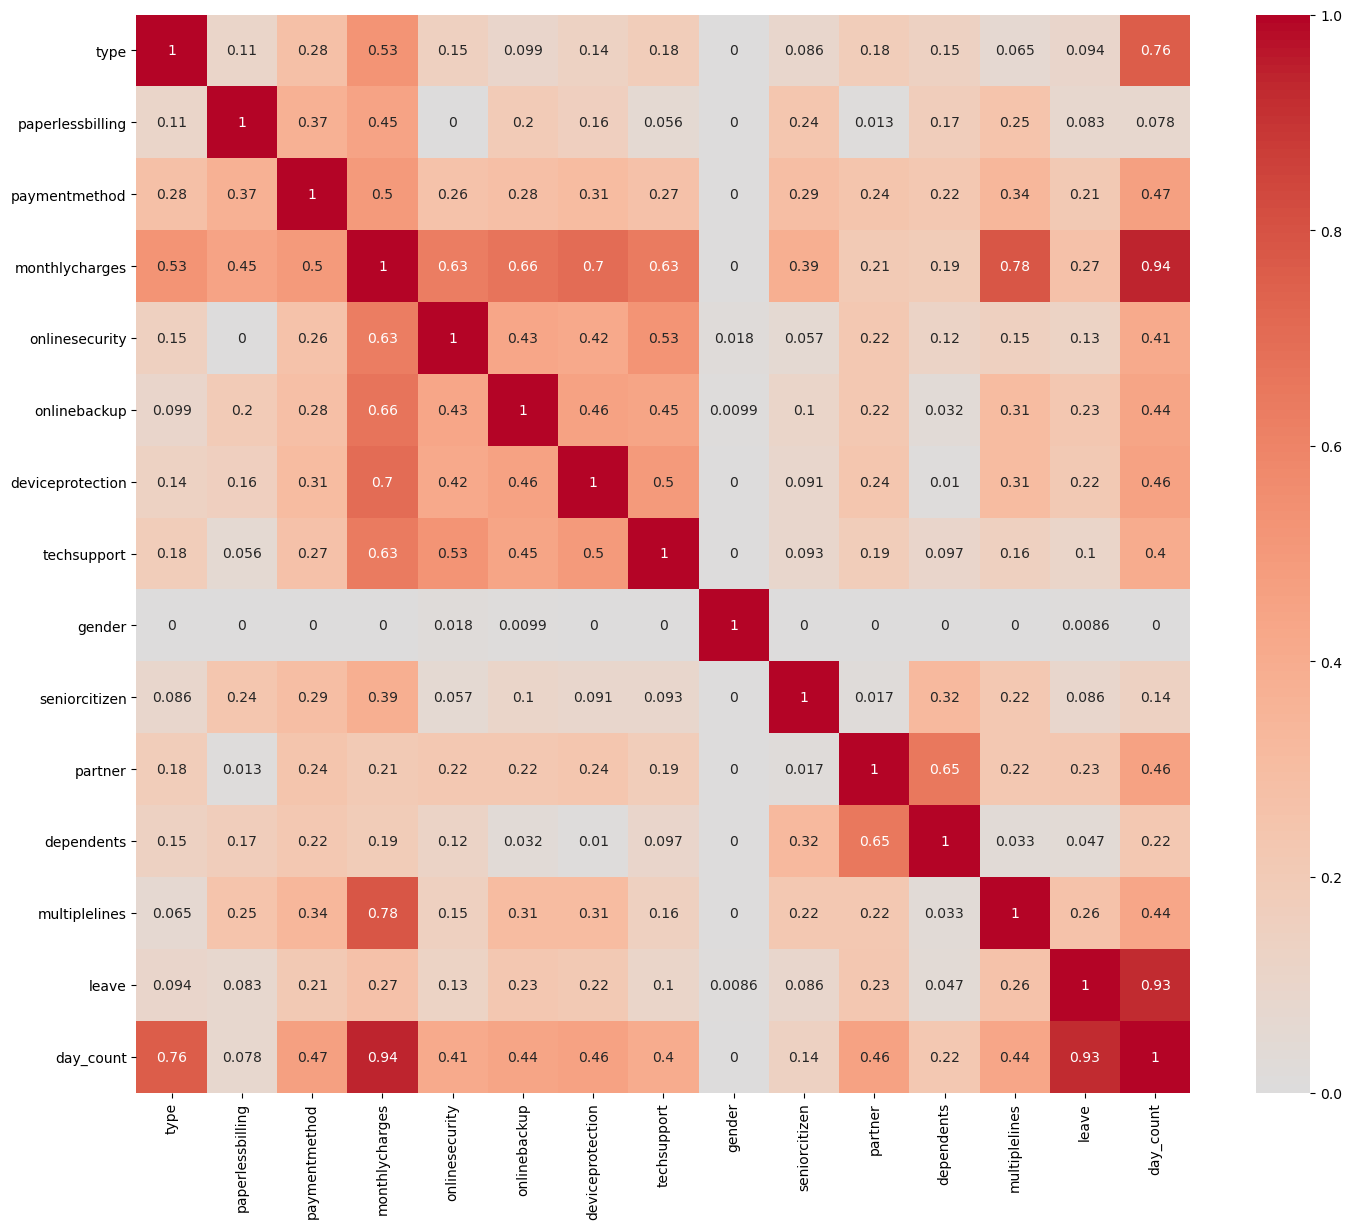

In [85]:
correlation_matrix = data_train_test.phik_matrix(interval_cols=['totalcharges', 'monthlycharges'])
plt.figure(figsize = (17,14))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, annot=True);

### Делим на выборки train/test

In [86]:
target = data_train_test['leave']
features = data_train_test.drop(['leave'] , axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target,
    test_size=0.25, 
    random_state=12345, 
    stratify=target
)

In [87]:
features_train.shape

(5282, 14)

In [88]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1999 to 5976
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              5282 non-null   object 
 1   paperlessbilling  5282 non-null   object 
 2   paymentmethod     5282 non-null   object 
 3   monthlycharges    5282 non-null   float64
 4   onlinesecurity    5282 non-null   object 
 5   onlinebackup      5282 non-null   object 
 6   deviceprotection  5282 non-null   object 
 7   techsupport       5282 non-null   object 
 8   gender            5282 non-null   object 
 9   seniorcitizen     5282 non-null   int64  
 10  partner           5282 non-null   object 
 11  dependents        5282 non-null   object 
 12  multiplelines     5282 non-null   object 
 13  day_count         5282 non-null   int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 619.0+ KB


In [89]:
target_train.shape

(5282,)

In [90]:
features_test.shape

(1761, 14)

In [91]:
target_test.shape

(1761,)

In [92]:
features_train_linear_model = features_train.copy()

In [93]:
categorical_features = ['type', 'paperlessbilling', 
                        'paymentmethod',
                        'onlinesecurity', 'onlinebackup',
                        'deviceprotection', 'techsupport',
                        'gender', 'partner',
                        'dependents', 'multiplelines', 
                        'seniorcitizen']
other_columns = list(set(features_train.columns) - set(categorical_features))

In [94]:
# закодируем категориальные признаки для всех моделей, кроме линейной для обучения

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=4)
encoder.fit(features_train[categorical_features])

train_ordinal_transform_df = pd.DataFrame(
    encoder.transform(features_train[categorical_features]), 
    columns=features_train[categorical_features].columns,
    index=features_train.index
)
features_train = pd.concat([features_train[other_columns], train_ordinal_transform_df], axis=1)
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1999 to 5976
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   monthlycharges    5282 non-null   float64
 1   day_count         5282 non-null   int64  
 2   type              5282 non-null   float64
 3   paperlessbilling  5282 non-null   float64
 4   paymentmethod     5282 non-null   float64
 5   onlinesecurity    5282 non-null   float64
 6   onlinebackup      5282 non-null   float64
 7   deviceprotection  5282 non-null   float64
 8   techsupport       5282 non-null   float64
 9   gender            5282 non-null   float64
 10  partner           5282 non-null   float64
 11  dependents        5282 non-null   float64
 12  multiplelines     5282 non-null   float64
 13  seniorcitizen     5282 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 619.0 KB


In [95]:
# закодируем категориальные признаки для логистической регрессии

ohe_linear_model = OneHotEncoder(sparse=False, handle_unknown='ignore')

train_transform_df = pd.DataFrame(
    ohe_linear_model.fit_transform(features_train_linear_model[categorical_features]), 
    columns=ohe_linear_model.get_feature_names(categorical_features),
    index=features_train_linear_model.index
)
features_train_linear_model = pd.concat([features_train_linear_model[other_columns], train_transform_df], axis=1)

In [96]:
features_train_linear_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1999 to 5976
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   monthlycharges                           5282 non-null   float64
 1   day_count                                5282 non-null   int64  
 2   type_Month-to-month                      5282 non-null   float64
 3   type_One year                            5282 non-null   float64
 4   type_Two year                            5282 non-null   float64
 5   paperlessbilling_No                      5282 non-null   float64
 6   paperlessbilling_Yes                     5282 non-null   float64
 7   paymentmethod_Bank transfer (automatic)  5282 non-null   float64
 8   paymentmethod_Credit card (automatic)    5282 non-null   float64
 9   paymentmethod_Electronic check           5282 non-null   float64
 10  paymentmethod_Mailed check               5282

### Исследуем баланс классов

In [97]:
class_frequency = data_train_test['leave'].value_counts(normalize=True)
class_frequency

0    0.843675
1    0.156325
Name: leave, dtype: float64

Соотношение классов 85/15

### Обучение моделей

#### Функции

In [98]:
# функция подбора гиперпараметров

def apply_randomized_search(model, params, features, target):
    scaler = StandardScaler()
    pipe = Pipeline(steps=[('scaler', scaler), ('classifier', model)])
    
    randomized_search = RandomizedSearchCV(
        pipe, params, scoring=['roc_auc', 'accuracy'], refit='roc_auc', n_jobs=-1, verbose=10, cv=3
    )
    randomized_search.fit(features, target)
    
    temp_model = randomized_search.best_estimator_.steps[1][1]
    if isinstance(temp_model, CatBoostClassifier):
        print(f'Лучшие подобранные параметры модели: \nCatBoostClassifier({temp_model._init_params})')
    else:
        print(f'Лучшие подобранные параметры модели: \n{temp_model}')
    
    return randomized_search

In [99]:
# функция ROC - кривой

def build_auc_roc_graph(model, features, target, name='ROC-кривая'):

    probabilities = model.predict_proba(features)
    probabilities_one = probabilities[:, 1]

    fpr, tpr, thresholds = roc_curve(target, probabilities_one) 

    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.show() 

In [100]:
# функция матрицы ошибок

def build_heatmap_error_matrix(data):
    plt.figure(figsize=(4, 4))
    
    graph = sns.heatmap(data, annot=True, fmt='.1f')
    graph.set_title('Матрица ошибок', fontdict={'fontsize': 14})
    plt.show()

In [101]:
# функция оценки важности признаков

def evaluate_importance_of_hyperparameters(trained_model, columns):
    if isinstance(trained_model, LogisticRegression):
        values = trained_model.coef_[0]
    elif isinstance(trained_model, RandomForestClassifier):
        values = trained_model.feature_importances_
    else:
        values = trained_model.get_feature_importance()
    
    series = pd.Series(values, columns)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    set_label(series.plot.bar(ax=ax), ('Признаки', 'Важность'), title='Оценка важности признаков')
    fig.tight_layout()

In [102]:
# функция предсказания и вывода метрик

def display_metrics(best_model, features, target):
    predict = best_model.predict(features)
    
#     print(f'ROC-AUC на лучшей модели: {roc_auc_score(target, predict)}')    
    print(f'Accuracy на лучшей модели: {accuracy_score(target, predict)}')
    print(f'Оценка ROC-AUC на кросс-валидации: {best_model.best_score_}')
    
    # Строим график AUC-ROC
    build_auc_roc_graph(best_model, features, target)
    
    # Матрица ошибок
    build_heatmap_error_matrix(confusion_matrix(target, predict))
    
    # Оценка важности признаков    
    evaluate_importance_of_hyperparameters(best_model.best_estimator_.steps[1][1], features.columns)

In [103]:
# функция, возвращающая лучшую модель

def simulate_model(model, params, features, target):
    best_model = apply_randomized_search(model, params, features, target)
    
    display_metrics(best_model, features, target)
    return  best_model

#### LogisticRegression

In [104]:
logistic_regression_params = {
    'classifier__C': [1, 2, 3, 5], 
    'classifier__fit_intercept': [True, False],
    'classifier__max_iter': range(50, 1001, 50),
    'classifier__solver': ['lbfgs', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие подобранные параметры модели: 
LogisticRegression(C=1, max_iter=850, random_state=80523, solver='newton-cg')
Accuracy на лучшей модели: 0.863498674744415
Оценка ROC-AUC на кросс-валидации: 0.7457964940432699


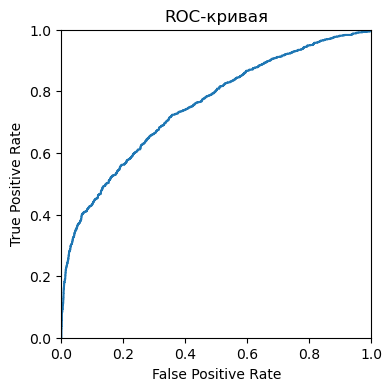

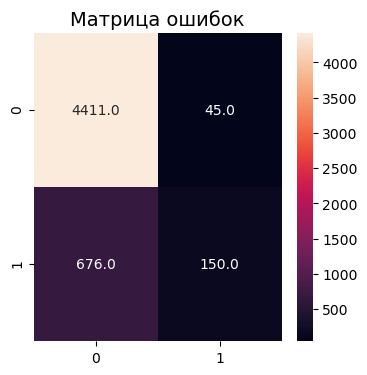

CPU times: user 1.22 s, sys: 326 ms, total: 1.55 s
Wall time: 752 ms


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              LogisticRegression(random_state=80523))]),
                   n_jobs=-1,
                   param_distributions={'classifier__C': [1, 2, 3, 5],
                                        'classifier__fit_intercept': [True,
                                                                      False],
                                        'classifier__max_iter': range(50, 1001, 50),
                                        'classifier__solver': ['lbfgs',
                                                               'newton-cg',
                                                               'lbfgs', 'sag',
                                                               'saga']},
                   refit='roc_auc', scoring=['roc_auc', 'accuracy'],
                   verbose=10)

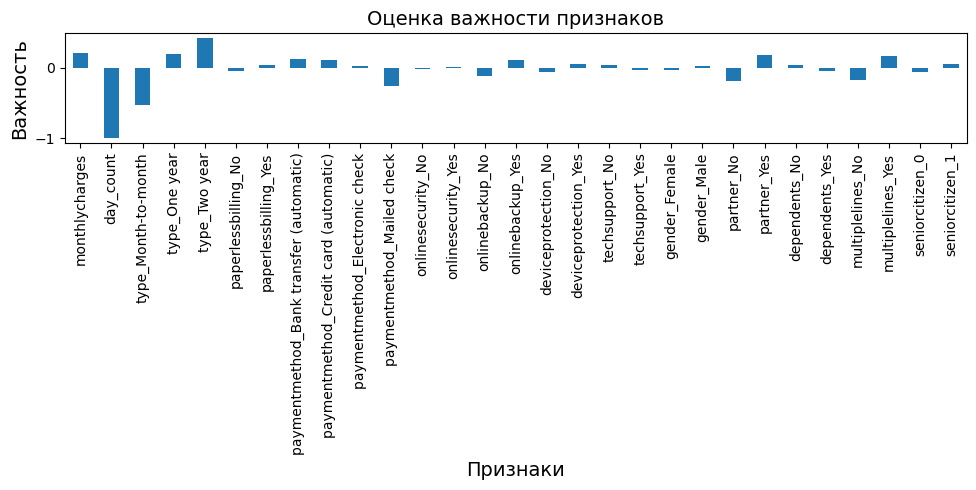

In [105]:
%%time
simplefilter(action='ignore')
simulate_model(
    LogisticRegression(random_state=80523),
    logistic_regression_params, 
    features_train_linear_model, 
    target_train
);

**LogisticRegression**

Лучшие подобранные параметры модели: 
- LogisticRegression(C=1, max_iter=500, random_state=80523)

По метрикам:
- Accuracy на лучшей модели: 0.863498674744415
- Оценка ROC-AUC на кросс-валидации: 0.7457956778000293

По матрице ошибок:
- правильная оценка положительного класса: 4411
- правильная оценка отрицательного класса: 45

По важности признаков:
- Самые неважные 'day_count', 'type_Month-to-month', 'paymentmethod_Mailed check'


##### Удаляем неважные признаки

In [106]:
features_train_log_reg = features_train_linear_model.drop(
    ['day_count', 'type_Month-to-month', 'paymentmethod_Mailed check'],
    axis=1
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие подобранные параметры модели: 
LogisticRegression(C=5, fit_intercept=False, max_iter=500, random_state=80523,
                   solver='newton-cg')
Accuracy на лучшей модели: 0.6037485800833018
Оценка ROC-AUC на кросс-валидации: 0.7095277575749934


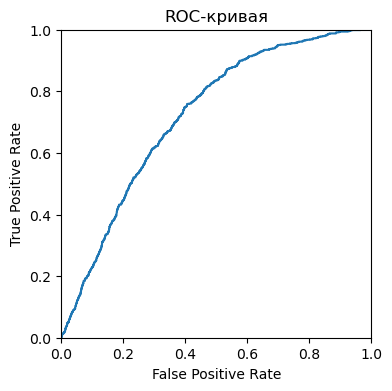

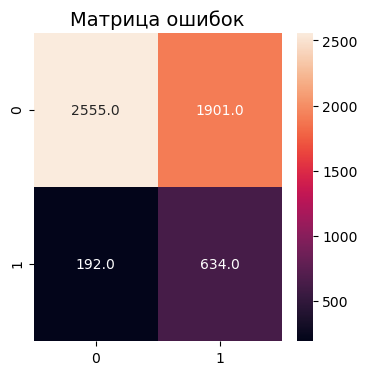

CPU times: user 1.09 s, sys: 309 ms, total: 1.4 s
Wall time: 577 ms


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              LogisticRegression(random_state=80523))]),
                   n_jobs=-1,
                   param_distributions={'classifier__C': [1, 2, 3, 5],
                                        'classifier__fit_intercept': [True,
                                                                      False],
                                        'classifier__max_iter': range(50, 1001, 50),
                                        'classifier__solver': ['lbfgs',
                                                               'newton-cg',
                                                               'lbfgs', 'sag',
                                                               'saga']},
                   refit='roc_auc', scoring=['roc_auc', 'accuracy'],
                   verbose=10)

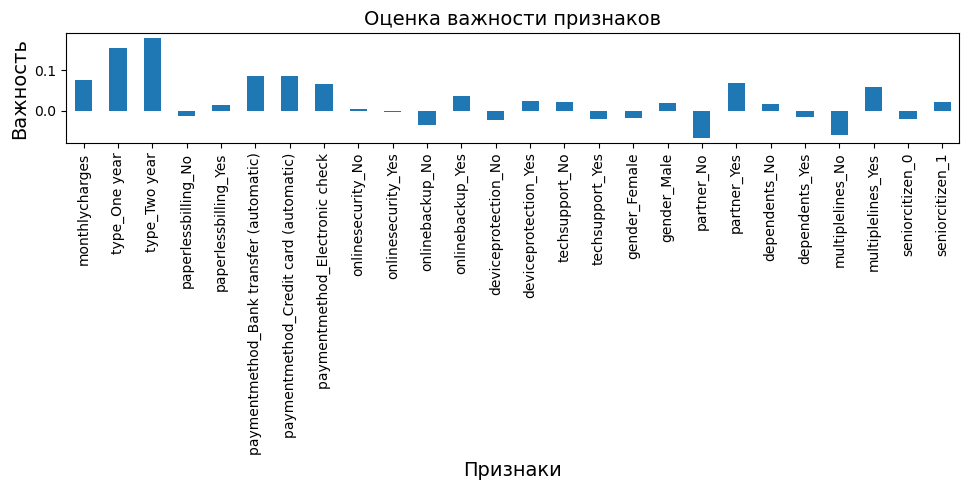

In [107]:
%%time
simulate_model(
    LogisticRegression(random_state=80523),
    logistic_regression_params,
    features_train_log_reg,
    target_train
)

**LogisticRegression с удалением неважных признаков**

Лучшие подобранные параметры модели: 
- LogisticRegression(C=5, fit_intercept=False, random_state=80523, solver='saga')

По метрикам:
- Accuracy на лучшей модели: 0.6039379023097312
- Оценка ROC-AUC на кросс-валидации: 0.7095261363688357

По матрице ошибок:
- правильная оценка положительного класса: 2556
- правильная оценка отрицательного класса: 1900


#### RandomForestClassifier

In [108]:
random_forest_params = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [2, 5, 10],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__min_samples_leaf': range(1, 5, 1),
    'classifier__n_estimators': range(100, 501, 100)
}

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 2/3; 3/10] START classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=450, classifier__solver=sag
[CV 2/3; 3/10] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=450, classifier__solver=sag; accuracy: (test=0.607) roc_auc: (test=0.774) total time=   0.1s
[CV 3/3; 6/10] START classifier__C=2, classifier__fit_intercept=True, classifier__max_iter=700, classifier__solver=sag
[CV 3/3; 6/10] END classifier__C=2, classifier__fit_intercept=True, classifier__max_iter=700, classifier__solver=sag; accuracy: (test=0.861) roc_auc: (test=0.714) total time=   0.1s
[CV 1/3; 10/10] START classifier__C=3, classifier__fit_intercept=True, classifier__max_iter=250, classifier__solver=saga
[CV 1/3; 10/10] END classifier__C=3, classifier__fit_intercept=True, classifier__max_iter=250, classifier__solver=saga; accuracy: (test=0.855) roc_auc: (test=0.751) total time=   0.0s
[CV 2/3; 2/10] START classifie

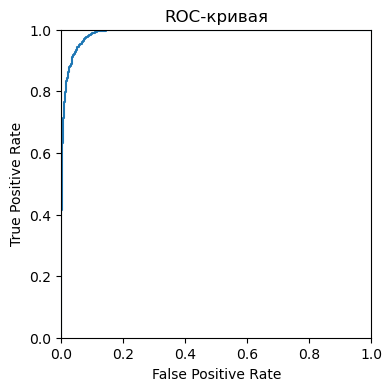

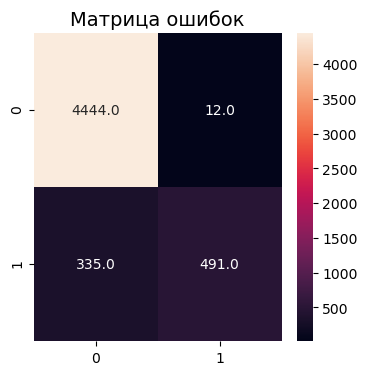

CPU times: user 3.14 s, sys: 79.7 ms, total: 3.22 s
Wall time: 10.2 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=80523))]),
                   n_jobs=-1,
                   param_distributions={'classifier__criterion': ['gini',
                                                                  'entropy'],
                                        'classifier__max_depth': [2, 5, 10],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2',
                                                                     None],
                                        'classifier__min_samples_leaf': range(1, 5),
                                        'classifier__n_estimators': range(100, 501, 100)},
                   refit='roc_auc', scoring=['roc_auc', 'accuracy'],
             

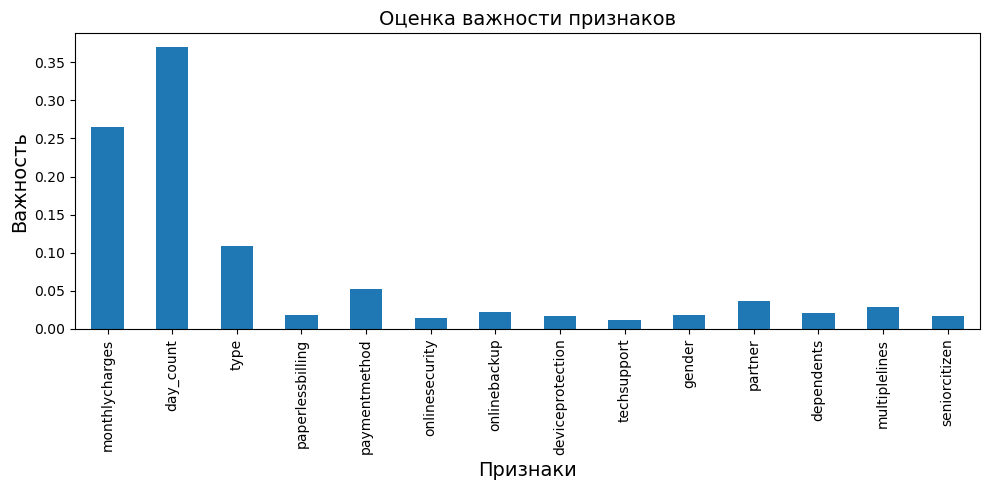

In [109]:
%%time
simulate_model(
    RandomForestClassifier(random_state=80523),
    random_forest_params,
    features_train,
    target_train
)

**RandomForestClassifier**

Лучшие подобранные параметры модели: 
- RandomForestClassifier(max_depth=10, max_features=None, n_estimators=200,
                       random_state=80523)
По метрикам:
- Accuracy на лучшей модели: 0.936198409693298
- Оценка ROC-AUC на кросс-валидации: 0.8282525810332068

По матрице ошибок:
- правильная оценка положительного класса: 4446
- правильная оценка отрицательного класса: 10

По важности признаков:
- Самые неважные 'paperlessbilling', 'seniorcitizen', 'dependents', 'techsupport', 'onlinesecurity'


##### Удаляем неважные признаки

In [110]:
features_train_rand_for = features_train.drop(
    [
        'paperlessbilling', 
        'seniorcitizen', 
        'dependents', 
        'techsupport',
        'onlinesecurity'
    ],
    axis=1
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие подобранные параметры модели: 
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                       min_samples_leaf=3, n_estimators=400,
                       random_state=80523)
Accuracy на лучшей модели: 0.9028776978417267
Оценка ROC-AUC на кросс-валидации: 0.8239345679213353


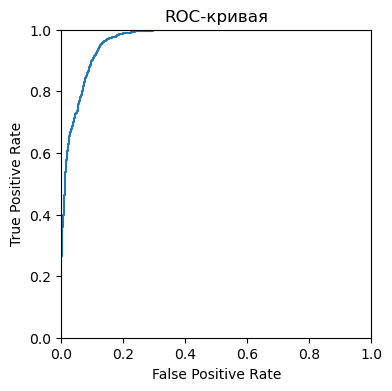

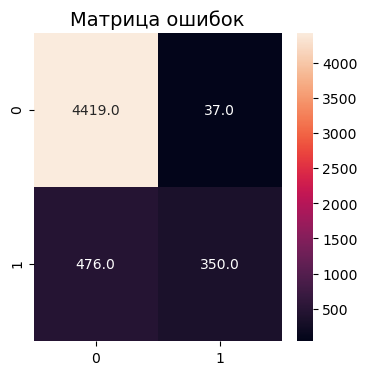

CPU times: user 2.94 s, sys: 30.8 ms, total: 2.97 s
Wall time: 7.81 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=80523))]),
                   n_jobs=-1,
                   param_distributions={'classifier__criterion': ['gini',
                                                                  'entropy'],
                                        'classifier__max_depth': [2, 5, 10],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2',
                                                                     None],
                                        'classifier__min_samples_leaf': range(1, 5),
                                        'classifier__n_estimators': range(100, 501, 100)},
                   refit='roc_auc', scoring=['roc_auc', 'accuracy'],
             

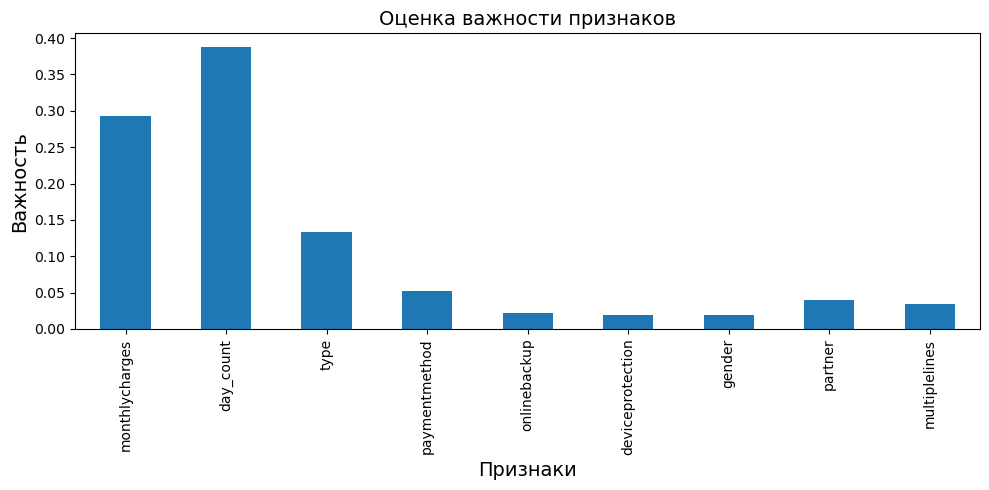

In [111]:
%%time
simulate_model(
    RandomForestClassifier(random_state=80523),
    random_forest_params,
    features_train_rand_for,
    target_train
)

**RandomForestClassifier с удалением неважных признаков**

Лучшие подобранные параметры модели: 

- RandomForestClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       min_samples_leaf=2, n_estimators=400,
                       random_state=80523)

По метрикам:
- Accuracy на лучшей модели: 0.8549791745550928
- Оценка ROC-AUC на кросс-валидации: 0.8239406242469233

По матрице ошибок:
- правильная оценка положительного класса: 4450
- правильная оценка отрицательного класса: 6


#### CatBoostClassifier

In [112]:
cat_boost_params = {
    'classifier__iterations': range(100, 501, 100),
    'classifier__depth': [5, 7, 10],
    'classifier__l2_leaf_reg': [5, 7, 10],
    'classifier__loss_function': ['Logloss', 'CrossEntropy'],
}

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 3/3; 2/10] START classifier__C=5, classifier__fit_intercept=True, classifier__max_iter=800, classifier__solver=lbfgs
[CV 3/3; 2/10] END classifier__C=5, classifier__fit_intercept=True, classifier__max_iter=800, classifier__solver=lbfgs; accuracy: (test=0.861) roc_auc: (test=0.714) total time=   0.0s
[CV 2/3; 5/10] START classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=850, classifier__solver=newton-cg
[CV 2/3; 5/10] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=850, classifier__solver=newton-cg; accuracy: (test=0.869) roc_auc: (test=0.772) total time=   0.0s
[CV 3/3; 5/10] START classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=850, classifier__solver=newton-cg
[CV 3/3; 5/10] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=850, classifier__solver=newton-cg; accuracy: (test=0.861) roc_auc: (test=0.714) total time=   0.0s
[CV 2/3;

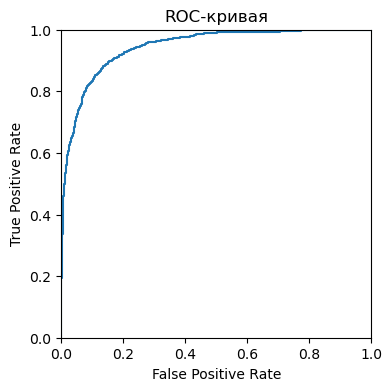

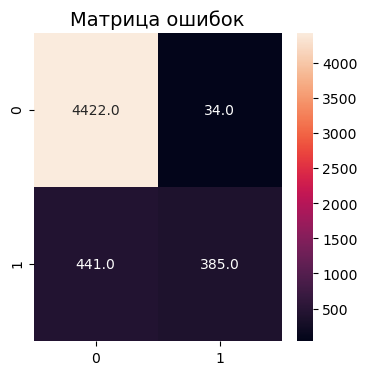

CPU times: user 1.71 s, sys: 780 ms, total: 2.49 s
Wall time: 17.7 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              <catboost.core.CatBoostClassifier object at 0x137566c10>)]),
                   n_jobs=-1,
                   param_distributions={'classifier__depth': [5, 7, 10],
                                        'classifier__iterations': range(100, 501, 100),
                                        'classifier__l2_leaf_reg': [5, 7, 10],
                                        'classifier__loss_function': ['Logloss',
                                                                      'CrossEntropy']},
                   refit='roc_auc', scoring=['roc_auc', 'accuracy'],
                   verbose=10)

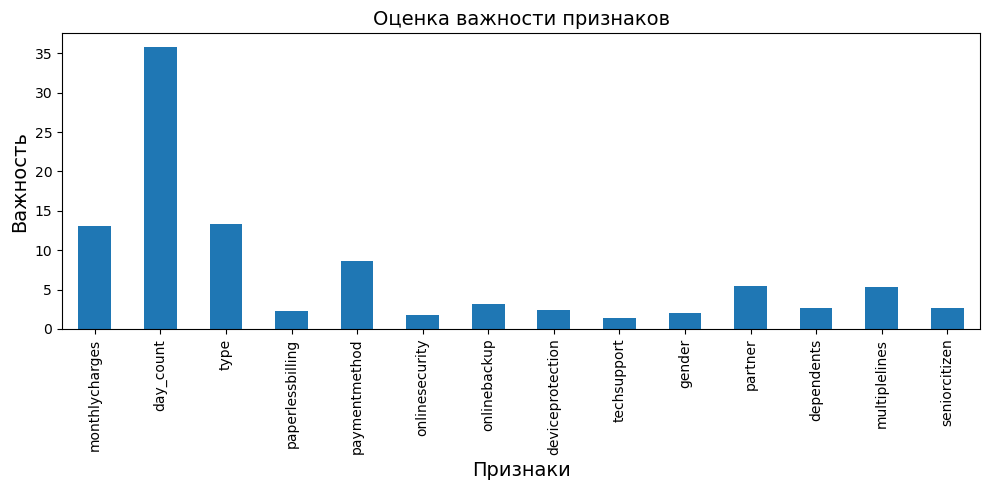

In [113]:
%%time
simulate_model(
    CatBoostClassifier(silent=True, random_state=80523, eval_metric='AUC'),
    cat_boost_params,
    features_train,
    target_train
)

**CatBoostClassifier**

Лучшие подобранные параметры модели: 
- CatBoostClassifier({'iterations': 500, 'depth': 7, 'l2_leaf_reg': 5, 'loss_function': 'CrossEntropy', 'silent': True, 'eval_metric': 'AUC', 'random_state': 80523})

По метрикам:
- Accuracy на лучшей модели: 0.9274895872775464
- Оценка ROC-AUC на кросс-валидации: 0.8570635633223486

По матрице ошибок:
- правильная оценка положительного класса: 4431
- правильная оценка отрицательного класса: 25

По важности признаков:
- Самые неважные 'paperlessbilling', 'techsupport', 'onlinesecurity'


##### Удаляем неважные признаки

In [114]:
features_train_cat_b = features_train.drop(
    [
        'paperlessbilling',
        'techsupport',
        'onlinesecurity'
    ],
    axis=1
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Лучшие подобранные параметры модели: 
CatBoostClassifier({'iterations': 500, 'depth': 5, 'l2_leaf_reg': 7, 'loss_function': 'Logloss', 'silent': True, 'eval_metric': 'AUC', 'random_state': 80523})
Accuracy на лучшей модели: 0.9011737978038622
Оценка ROC-AUC на кросс-валидации: 0.856282442803452


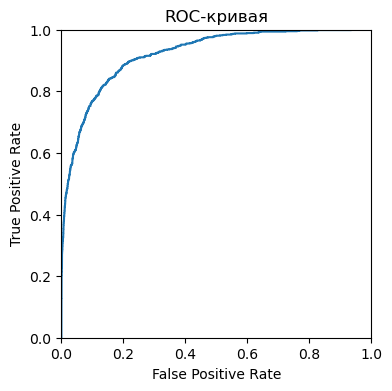

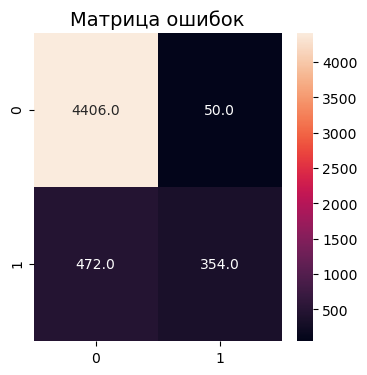

CPU times: user 1.21 s, sys: 629 ms, total: 1.84 s
Wall time: 6.98 s


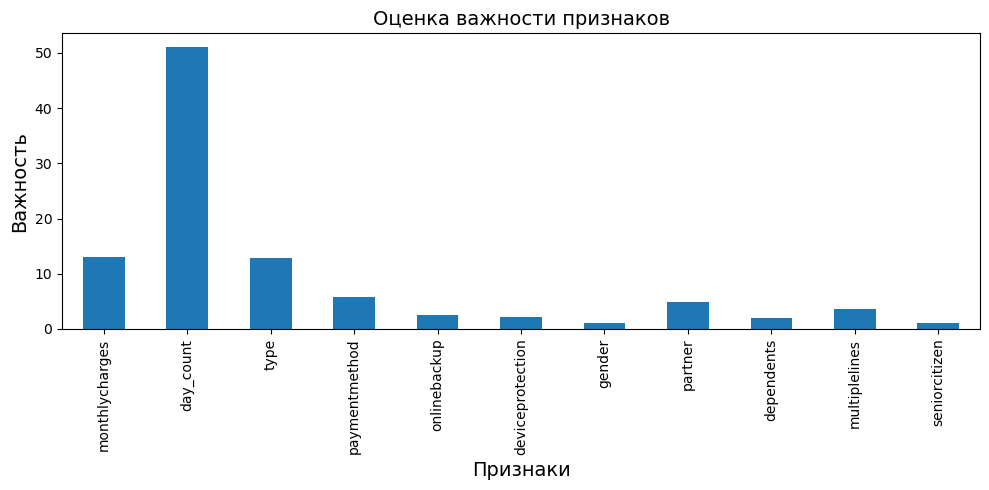

In [115]:
%%time
best_model = simulate_model(
    CatBoostClassifier(silent=True, random_state=80523, eval_metric='AUC'),
    cat_boost_params,
    features_train_cat_b,
    target_train
)

**CatBoostClassifier с удалением неважных признаков**

Лучшие подобранные параметры модели: 
- CatBoostClassifier({'iterations': 500, 'depth': 7, 'l2_leaf_reg': 7, 'loss_function': 'Logloss', 'silent': True, 'eval_metric': 'AUC', 'random_state': 80523})

По метрикам:
- Accuracy на лучшей модели: 0.9193487315410829
- Оценка ROC-AUC на кросс-валидации: 0.8574141228796229

По матрице ошибок:
- правильная оценка положительного класса: 4427
- правильная оценка отрицательного класса: 29

### Сводная таблица исследуемых моделей

In [116]:
index = ['LogisticRegression', 
         'LogisticRegression с удалением неважных признаков', 
         'RandomForestClassifier', 
         'RandomForestClassifier с удалением неважных признаков', 
         'CatBoostClassifier',
         'CatBoostClassifier с удалением неважных признаков']
data = {
    'Accuracy модели': [0.86, 0.60, 0.93, 0.85, 0.90, 0.90],
    'Оценка AUC-ROC на кросс-валидации': [0.74, 0.70, 0.82, 0.82, 0.85, 0.85]
}

In [117]:
scores_data = pd.DataFrame(data=data, index=index)

In [118]:
scores_data

,Accuracy модели,Оценка AUC-ROC на кросс-валидации
LogisticRegression,0.86,0.74
LogisticRegression с удалением неважных признаков,0.60,0.70
RandomForestClassifier,0.93,0.82
RandomForestClassifier с удалением неважных признаков,0.85,0.82
CatBoostClassifier,0.90,0.85
CatBoostClassifier с удалением неважных признаков,0.90,0.85


#### Вывод
На основании представленных данных, выбираю модель CatBoostClassifier с удалением неважных признаков для финального тестирования

### Финальное тестирование

In [119]:
# закодируем категориальные признаки для теста

test_ordinal_transform_df = pd.DataFrame(
    encoder.transform(features_test[categorical_features]), 
    columns=features_test[categorical_features].columns,
    index=features_test.index
)
features_test = pd.concat([features_test[other_columns], test_ordinal_transform_df], axis=1)
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761 entries, 6843 to 4017
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   monthlycharges    1761 non-null   float64
 1   day_count         1761 non-null   int64  
 2   type              1761 non-null   float64
 3   paperlessbilling  1761 non-null   float64
 4   paymentmethod     1761 non-null   float64
 5   onlinesecurity    1761 non-null   float64
 6   onlinebackup      1761 non-null   float64
 7   deviceprotection  1761 non-null   float64
 8   techsupport       1761 non-null   float64
 9   gender            1761 non-null   float64
 10  partner           1761 non-null   float64
 11  dependents        1761 non-null   float64
 12  multiplelines     1761 non-null   float64
 13  seniorcitizen     1761 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 206.4 KB


In [120]:
features_test_cat_b = features_test.drop(
    [
        'paperlessbilling',
        'techsupport',
        'onlinesecurity'
    ],
    axis=1
)

In [121]:
target_predict = best_model.predict_proba(features_test_cat_b)

In [122]:
roc_auc_cat_test = roc_auc_score(target_test, target_predict[:, 1])
roc_auc_cat_test

0.8755609935152331

**CatBoostClassifier на тесте 0.87** 

### Вывод по моделированию

#### Шаги

- Были отобраны признаки для итоговой таблицы:
        - leave - целевой признак, показывающий ушел клиент или остался
        - day_count - количество дней контракта
        - monthlycharges - ежемесячные платежи по контракту за все время пользования услугами
        - type - тип оплаты (помесячно, раз в год и т.п)
        - paymentmethod - метод оплаты (карта, чек и т.п)
        - techsupport - использование тех поддержки
        - seniorcitizen - есть пенсионный статус или нет
        - partner - наличие супруга
        - multiplelines - использование телефонных линий
        - paperlessbilling - электронный платежный документ
        - onlinesecurity - безопасность в интернете
        - onlinebackup - онлайн-резервное копирование
        - deviceprotection - защита устройства
        - gender - пол пользователя
        - dependents - наличие иждивенцев
- Категориальные признаки были закодированы методом OrdinalEncoder()
- Для линейной модели кодирование произвела с помощью OneHotEncoder()
- Исследован баланс классов (соотношение 85/15)
- Отобраны модели для построения прогноза: линейная регрессия, случайный лес и catboost
- Выполнен автоматический подбор гиперпараметров всех моделей с помощью RandomizedSearchCV()
- Выполнено обучение моделей на лучших гиперпараметрах
- Построена матрица ошибок для всех моделей
- Выполнена оценка важности признаков для всех моделей
- Построена ROC кривая для всех моделей
- Выведены требуемые метрики: AUC-ROC, Accuracy
- Проведена оценка каждой модели на кросс-валидации

#### Сводная таблица исследуемых моделей

In [123]:
scores_data

,Accuracy модели,Оценка AUC-ROC на кросс-валидации
LogisticRegression,0.86,0.74
LogisticRegression с удалением неважных признаков,0.60,0.70
RandomForestClassifier,0.93,0.82
RandomForestClassifier с удалением неважных признаков,0.85,0.82
CatBoostClassifier,0.90,0.85
CatBoostClassifier с удалением неважных признаков,0.90,0.85


Лучшая модель CatBoostClassifier  с удалением неважных признаков - roc auc 0.85

#### Оценка важности признаков лучшей модели:

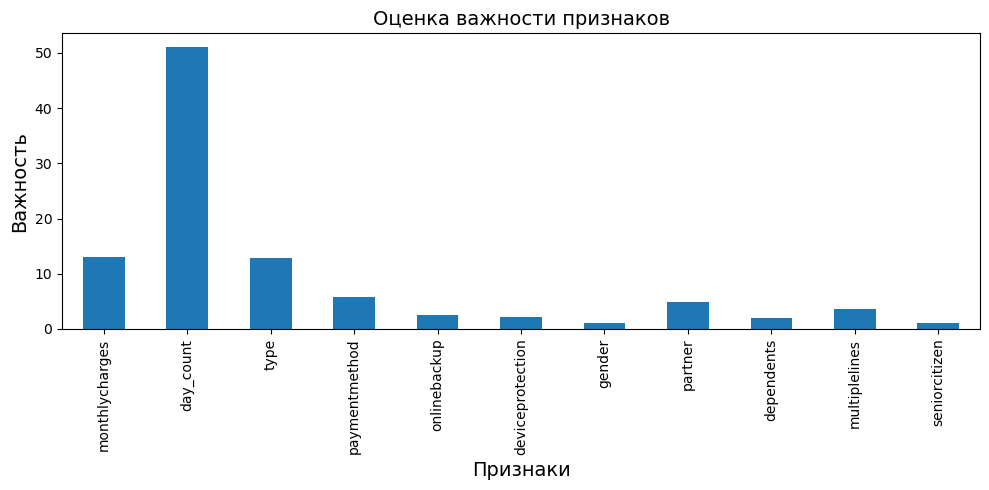

In [124]:
evaluate_importance_of_hyperparameters(best_model.best_estimator_.steps[1][1], features_test_cat_b.columns)

Удаление неважных признаков не помогло, хз, зачем вообще тогда смотреть на важность признаков, как это поможет)

## Отчет

### Предобработка данных и EDA


#### Первичный осмотр

- в data_contract и data_personal по 7043 записи. В data_internet 5517 записей, data_phone - 6361 запись
- во всех таблицах нет пропусков, дубликатов и столбцы записаны с использованием заглавных и строчных букв (привела к нижнему регистру)
- в data_contract измененила типы данных столбцов BeginDate, EndDate и TotalCharges
- большинство данных категориальные, нужно будет переводить в числовые
- Очевидно, таблицы нужно объединить для дальнейшего EDA

#### Объединение данных

- Объединила 4 таблицу в одну без потери данных
- Обработала пропуски:
    - Самое большое кол-во пропусков в столбцах из файла data_internet
    - Все эти столбцы категориальные и все, кроме internetservice содержат значения 'yes'/'no'. В этих столбцах пропуски заполнила значением no, так как у пользователей с пропусками скорее всего интернета нет.
    - internetservice заполнила значением no_internet
    - Пропуски в multiplelines заполнила значением no_phone
- Аномалии не выявлены
- Дубликатов нет
   

#### Исследовательский анализ

- Провела исследовательский анализ. Проверила зависимость ухода клиента от следующих признаков:
    - Количество дней, прошедших от начала до конца договора.
        - Да, зависит. 
        - Корреляция средняя
        - Все ушедшие клиенты пользовались услугами от 0 до 2000 дней
        - Все оставшиеся клиенты пользуются услугами от 1400 до 3700 дней
    - Какой тип оплаты используется пользователями оставшимися и ушедшими (type):
        - Корреляция очень слабая
        - Ушедшие пользователи в основном платили помесячно и раз в 2 года
    - Способ оплаты (paymentmethod):
        - Корреляция слабая
        - Ушедшие пользователи оплачивали услуги по большей части электронным чеком
    - Ежемесячные траты на услуги по договору (monthlycharges)
        - Корреляция слабая
        -  У ушедших пользователей стартовый ценник ежемесячного платежа почти в 2 раза больше. И распределение по суммам выше, чем у активных пользователей.
    - Всего потрачено денег на услуги (totalcharges)
        - Корреляция высокая
        - Всего уплаченных средств также больше у ушедших пользователей
    - Как влияет наличие иждивенцев на уход (dependents)
        - Корреляция очень слабая
        - Распределение одинаковое, зависимости нет
    - Как влияет наличие пенсионного статуса на уход (seniorcitizen)
        - Корреляция очень слабая
        - Распределение одинаковое, зависимости нет
    - Как влияет наличие супруга (partner)
        - Корреляция слабая
        - Взаимосвязь по графику слабая. Видно, что люди без партнера - основные пользователи компании. Но не скажу, что это сильно влияет на уход, хоть и бОльшее количество людей с партнером из ушедших.
    - Зависимость от использования интерент услуг (internetservice, streamingtv, streamingmovies)
        - Корреляция слабая у streamingtv, streamingmovies. Очень слабая у internetservice
        - Зависимость слабая. Из ушедших пользователей чуть больше тех, кто пользовался стриминговым тв и фильмами

### Подготовка данных и моделирование


#### Проделанные шаги

- Были отобраны признаки для итоговой таблицы:
        - leave - целевой признак, показывающий ушел клиент или остался
        - day_count - количество дней контракта
        - monthlycharges - ежемесячные платежи по контракту за все время пользования услугами
        - type - тип оплаты (помесячно, раз в год и т.п)
        - paymentmethod - метод оплаты (карта, чек и т.п)
        - techsupport - использование тех поддержки
        - seniorcitizen - есть пенсионный статус или нет
        - partner - наличие супруга
        - multiplelines - использование телефонных линий
        - paperlessbilling - электронный платежный документ
        - onlinesecurity - безопасность в интернете
        - onlinebackup - онлайн-резервное копирование
        - deviceprotection - защита устройства
        - gender - пол пользователя
        - dependents - наличие иждивенцев
        
- Данные признаки были закодированы двумя способами:
    - OrdinalEncoder для всех моделей
    - OneHotEncoder для линейной модели
    - и далее стандартизированы c использованием StandardScaler
    - Категориальные признаки были закодированы методом OrdinalEncoder()

- Исследован баланс классов (соотношение 85/15)
- Отобраны модели для построения прогноза: линейная регрессия, случайный лес и catboost
- Выполнен автоматический подбор гиперпараметров всех моделей с помощью RandomizedSearchCV()
- Выполнено обучение моделей на лучших гиперпараметрах
- Построена матрица ошибок для всех моделей
- Выполнена оценка важности признаков для всех моделей
- Построена ROC кривая для всех моделей
- Выведены требуемые метрики: AUC-ROC, Accuracy
- Проведена оценка каждой модели на кросс-валидации

#### Результаты моделирования

In [125]:
scores_data

,Accuracy модели,Оценка AUC-ROC на кросс-валидации
LogisticRegression,0.86,0.74
LogisticRegression с удалением неважных признаков,0.60,0.70
RandomForestClassifier,0.93,0.82
RandomForestClassifier с удалением неважных признаков,0.85,0.82
CatBoostClassifier,0.90,0.85
CatBoostClassifier с удалением неважных признаков,0.90,0.85


Лучшая модель CatBoostClassifier с удалением неважных признаков - auc roc 0.85

#### Оценка на тесте лучшей модели

**ROC-AUC на лучшей модели: 0.87**

##### Оценка важности признаков лучшей модели

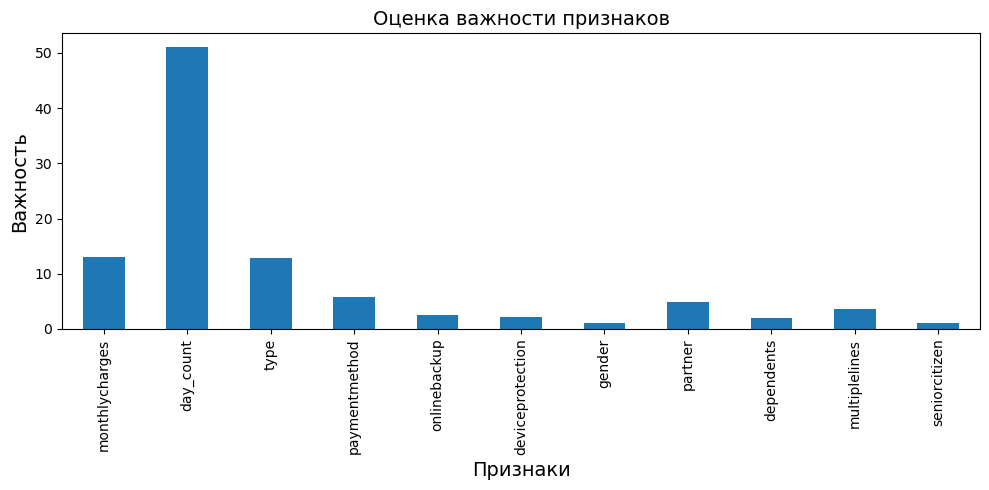

[CV 1/3; 1/10] START classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__solver=saga
[CV 1/3; 1/10] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__solver=saga; accuracy: (test=0.855) roc_auc: (test=0.751) total time=   0.1s
[CV 1/3; 5/10] START classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=850, classifier__solver=newton-cg
[CV 1/3; 5/10] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=850, classifier__solver=newton-cg; accuracy: (test=0.855) roc_auc: (test=0.751) total time=   0.0s
[CV 1/3; 6/10] START classifier__C=2, classifier__fit_intercept=True, classifier__max_iter=700, classifier__solver=sag
[CV 1/3; 6/10] END classifier__C=2, classifier__fit_intercept=True, classifier__max_iter=700, classifier__solver=sag; accuracy: (test=0.855) roc_auc: (test=0.751) total time=   0.1s
[CV 3/3; 9/10] START classifier__C=1, classifier__fit_intercept=False, classifier__

In [126]:
evaluate_importance_of_hyperparameters(best_model.best_estimator_.steps[1][1], features_test_cat_b.columns)

В данном случае удаление наименее важных признаков привело к улучшению метрик, как видно на графике, остались признаки, влияющие на результат.

#### Анализ соответствия фактической работы запланированным шагам

**Запланированные шаги**

1. Предобработка данных и EDA
    - Первичный осмотр файлов
    - Объединение данных
    - Обработка пропусков, аномалий, дубликатов
    - Исследовательский анализ, 
        - Оценка зависимости целевого признака от других признаков на графиках
        - Исследуем корреляцию, в том числе категориальных признаков
2. Подготовка данных и моделирование
    - Выполняем отбор признаков
    - Готовим итоговую таблицу
    - Разделить на выборки (обучающую и тестовую)
    - Исследовать баланс классов
    - Обучить разные модели (не менее 2х) и найти лучшую.
        - Подбираем гиперпараметры, оцениваем модели на кросс-валидации.
    - Анализ важности признаков
    - Анализ матрицы ошибок
    - финальное тестирование
3. Отчет

**Фактическая работа полностью соответсвует запланированному плану**
